<a href="https://colab.research.google.com/github/anomaitech/GSL-basin/blob/main/gwdm_aquifermapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Groundwater Level Mapping Script**

This scripts reads reads the following three sets of input:

1. An **aquifer** file in GEOJSON or shapefile format
2. A CSV file of **well locations**
3. A CSV file of **water level measurements** (time series file)

The script then downloads a dataset of GLDAS soil moisture and imputes gaps in water level time series using a machine learning algorithm, resulting in a complete time series with monthly water level values for each well. These values are then interpolated spatially at selected intervals using kriging to generate a set of time-varying rasters of groundwater level elevations stored in a netCDF file. This file is then processed to calculate a time series of groundwater storage change for the aquifer. Finally, an animated gif is generated of the water levels.   

The file formats used for the aquifer, well, and measurements files are described here:

https://gwdm.readthedocs.io/en/latest/datapreparation.html

The mapping algorithm is described in more detail here:

https://gwdm.readthedocs.io/en/latest/mapping.html

The netCDF file generated by this algorithm can be uploaded to the Groundwater Data Mapper (GWDM) Tethys application for visualization as described here:

https://gwdm.readthedocs.io/en/latest/importingdata.html#rasters


## **Instructions:**

*This is a Google Colab Notebook. That means that you can perform operations within this notebook and download your files once you're done. Once you restart the session (e.g. refresh the page) your changes will not be saved. However, you can save a copy of this notebook using the "File" tab.*

* To use this tool, follow the instructions in the right side of each cell.
* **To run each cell, press the play button on the left. Occasionally, the cell will require additional input after pressing the play button.**
* If an error appears, double check that all input options are correct.
* After all cells have been run, a set of files will be generated, which can be downloaded from the "Files" window on the left.

# Install Packages

In [1]:
#@markdown ### **Installing packages**
%%capture
!pip install rioxarray
!pip install gstools
!pip install netCDF4
!pip install xlsxwriter

In [2]:
#@markdown ### **Importing packages**
import calendar
import copy
import datetime
import math
import os
import shutil
import tempfile
import time
import urllib
from pathlib import Path
from timeit import default_timer as timer
from urllib import request
from xml.etree import cElementTree as ET
from datetime import date

import geopandas as gpd
import netCDF4
import gstools as gs
import numpy as np
import pandas as pd
import requests
import xarray
import rioxarray
from scipy import interpolate
from shapely import wkt
from shapely.geometry import mapping
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
import re
import ipywidgets as widgets
import plotly.express as px
import xlsxwriter

In [3]:
#@markdown ### **Initializing Summary Logging**
# Initialize summary string to record analysis inputs, parameters, etc
summary = "SUMMARY - Groundwater Level Mapping Analysis\n"
summary += f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}\n"

# Uploading Aquifer Data

In [4]:
#@markdown ### **Defining functions for this section**

# looks through columns in dataframe to find matches to use as default for widgets
def find_default_column(possible_names, columns):
    lower_columns = [column.lower() for column in columns]
    for name in possible_names:
        if name.lower() in lower_columns:
            return columns[lower_columns.index(name.lower())]
    return columns[0]

In [5]:
#@markdown ### **Uploading Aquifer File**
upload_aquifers = files.upload()
aquifers = gpd.GeoDataFrame.from_file(list(upload_aquifers.keys())[0])

aList1 = list(aquifers.columns)

default_a_ID = find_default_column(['AquiferID', 'Aquifer_ID'], aList1)
default_a_name = find_default_column(['Aquifer_Name', "AquiferName", "Name"], aList1)

a_ID = widgets.Dropdown(options=aList1, value=default_a_ID, description = "Aquifer ID")
a_name = widgets.Dropdown(options=aList1, value=default_a_name, description = "Aquifer Name")

a1Items = [a_ID, a_name]
print("\nPlease select the appropriate headers for your file")
widgets.GridBox(a1Items, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving gls_basin.zip to gls_basin.zip

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Aquifer ID', options=('OBJECTID_1', 'OBJECTID_2', 'NAME', 'BASIN', 'sq…

In [6]:
#@markdown ### **Select the Aquifer you would like to Map**
aList2 = list(aquifers[a_name.value])
aquifer_name = widgets.Dropdown(options=aList2, description = "Aquifer Name")

a2Items = [aquifer_name]
print("\nPlease select the aquifer you would like to map")
widgets.GridBox(a2Items, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))


Please select the aquifer you would like to map


GridBox(children=(Dropdown(description='Aquifer Name', options=('GSL Basin',), value='GSL Basin'),), layout=La…

In [7]:
#@markdown ### **Filter and Display Aquifer Information**
summary += f"aquifer file name: {list(upload_aquifers.keys())[0]}\n"
summary += f"selected aquifer: {aquifer_name.value}\n"
aquifer_index = aquifers[aquifers[a_name.value]==aquifer_name.value].index.values
aquifer = aquifers[aquifers[a_name.value].isin([aquifer_name.value])]
aquifer_ID = list(aquifer[a_ID.value])
aquifer

,OBJECTID_1,OBJECTID_2,NAME,BASIN,sqmi,Acres,AllReports,FullRept99,FullRept10,NonDigital,...,Shape_Leng,Gaz_ID,HUC_6,HU_6_Name,TNMID,Shape_Le_1,Shape_Le_2,Shape_Area,Area_mi2,geometry
0,0,1,GSL Basin,01,787.035296,503705.0,http://water.utah.gov/Landuse/publ.htm,http://water.utah.gov/Landuse/wrlui.pdf,http://water.utah.gov/Landuse/StatewideSummary...,None,...,269759.984642,0,None,None,None,269759.984642,2.811615,0.217221,787.548119,"MULTIPOLYGON (((-114.05234 38.05464, -114.0528..."


In [8]:
#@markdown ### **Uploading wells file**
upload_wells = files.upload()
wells = pd.read_csv(list(upload_wells.keys())[0])

wList = list(wells.columns)
wList.append('NA')

# find defaults for widgets
default_w_ID = find_default_column(['WellID', 'Well_ID'], wList)
default_w_name = find_default_column(['WellName', 'Well_Name'], wList)
default_w_lat = find_default_column(['Latitude', 'Lat', 'lat_dec'], wList)
default_w_long = find_default_column(['Longitude', 'long', 'long_dec'], wList)
default_w_aquifer_ID = find_default_column(['AquiferID', 'Aquifer_ID'], wList)

w_well_ID = widgets.Dropdown(options=wList, value=default_w_ID, description = "Well ID")
w_well_name = widgets.Dropdown(options=wList, value=default_w_name, description = "Well Name")
w_lat = widgets.Dropdown(options=wList, value=default_w_lat, description = "Latitude")
w_long = widgets.Dropdown(options=wList, value=default_w_long, description = "Longitude")
w_aquifer_ID = widgets.Dropdown(options=wList, value=default_w_aquifer_ID, description = "Aquifer ID")

wItems = [w_well_ID, w_well_name, w_lat, w_long, w_aquifer_ID]
print("\nPlease select the appropriate headers for your file")
widgets.GridBox(wItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving GSLB_1900-2023_wells_with_aquifers.csv to GSLB_1900-2023_wells_with_aquifers.csv

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Well ID', options=('Well_ID', 'Well_Name', 'lat_dec', 'long_dec', 'GSE…

In [9]:
#@markdown ### **Formatting wells dataframe**
#To avoid type mismatch, convert the aquifer_id found from the aquifer file and the aquiferid column
#in the wells dataframe to both be strings
summary += f"well file name: {list(upload_wells.keys())[0]}\n"
aquifer_ID = [str(item) for item in aquifer_ID]
if (w_aquifer_ID.value !="NA"):
  wells[w_aquifer_ID.value] = wells[w_aquifer_ID.value].astype(str)

wells_gdf = gpd.GeoDataFrame(wells, geometry=gpd.points_from_xy(wells[w_long.value], wells[w_lat.value]))
if (w_aquifer_ID.value !="NA"):
  wells_gdf = wells_gdf[wells_gdf[w_aquifer_ID.value].isin(aquifer_ID)]
wells_gdf.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State,geometry
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT,POINT (-113.80275 38.1758)
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT,POINT (-113.7955 38.17631)
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT,POINT (-113.74117 38.19783)
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT,POINT (-113.8155 38.21003)
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT,POINT (-113.73247 38.35357)


<Axes: >

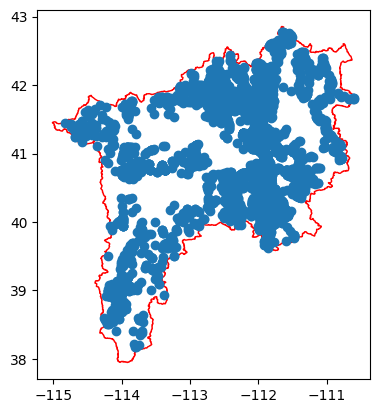

In [10]:
#@markdown ### **Plotting aquifer and wells**
fig, ax = plt.subplots()
aquifer.plot(color="none", edgecolor="red", ax=ax)
wells_gdf.plot(ax=ax)

In [10]:
#@markdown ### **Uploading timeseries**
upload_timeseries = files.upload()
measurements = pd.read_csv(list(upload_timeseries.keys())[0])

tList = list(measurements.columns)
tList.append('NA')

default_t_well_ID = find_default_column(['WellID', 'Well_ID'], tList)
default_t_date = find_default_column(['Date'], tList)
default_t_measurement = find_default_column(['WTE'], tList)
default_t_aquifer_ID = find_default_column(['AquiferID', 'Aquifer_ID'], tList)

ts_well_ID = widgets.Dropdown(options=tList, value=default_t_well_ID, description = "Well ID")
ts_date = widgets.Dropdown(options=tList, value=default_t_date, description = "Date")
ts_measurement = widgets.Dropdown(options=tList, value=default_t_measurement, description = "Measurement")
ts_aquifer_ID = widgets.Dropdown(options=tList, value=default_t_aquifer_ID, description = "Aquifer ID")

tItems = [ts_well_ID, ts_date, ts_measurement, ts_aquifer_ID]

print("\nPlease select the appropriate headers for your file")
widgets.GridBox(tItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving GSLB_1900-2023_TS_with_aquifers.csv to GSLB_1900-2023_TS_with_aquifers.csv

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Well ID', index=1, options=('AquiferID', 'Well_ID', 'Date', 'WTE', 'St…

In [11]:
#@markdown ### **Select units for water level measurements**
len_units = "ft" #@param ["m", "ft"]

In [12]:
#@markdown ## **Formatting Timeseries**
#@markdown #### Run this cell to coerce datatypes, convert dates, and filter for the specific aquifer
#@markdown #### After running cell, verify that the date format is correctly parsed.

summary += f"time series file name: {list(upload_timeseries.keys())[0]}\n"

#To avoid type mismatch datatypes
if (ts_aquifer_ID.value !="NA"):
  measurements[ts_aquifer_ID.value] = measurements[ts_aquifer_ID.value].astype(str)

#converting date format
measurements[ts_date.value] = pd.to_datetime(measurements[ts_date.value])

#filtering by aquifer if aquiferIDs are included in the dataset
if (ts_aquifer_ID.value !="NA"):
  measurements = measurements[measurements[ts_aquifer_ID.value].isin(aquifer_ID)]
measurements.head()

,AquiferID,Well_ID,Date,WTE,State
0,1,381033113480701,2012-09-06,7092.99,UT
1,1,381037113474001,2012-09-06,7175.95,UT
2,1,381152113442801,1995-11-22,6200.00,UT
3,1,381236113485601,2014-07-23,7151.00,UT
4,1,382113113435401,2008-09-03,5395.95,UT


In [13]:
#@markdown ### **Dropping measurements that don't have corresponding wells**
no_uniquewells = len(measurements[ts_well_ID.value].unique())
measurements = measurements[measurements[ts_well_ID.value].isin(wells_gdf[w_well_ID.value])].reset_index(drop=True)
no_wells = len(wells_gdf[w_well_ID.value].unique())
summary += f"number of wells in wells file: {no_wells}\n"
summary += f"unique well IDs referenced in time series file: {no_uniquewells}\n"
print(no_wells, ' total wells in well file')
print(no_uniquewells, ' unique well IDs referenced in measurements file')

8752  total wells in well file
8602  unique well IDs referenced in measurements file


In [14]:
#@markdown ### **Defining aquifer bounds**
bbox = aquifer.bounds.values[0].tolist()
bbox

[-115.00992021108834,
 37.947163021306665,
 -110.59847552418574,
 42.85578333972916]

# Accessing Data from Server

In [15]:
#@markdown ### **Defining functions for this section**
from io import StringIO

def get_time_bounds(url):
    # gio's new get_time_bounds
    # This function returns the first and last available time
    # from a url of a getcapabilities page located on a Thredds Server
    f = urllib.request.urlopen(url)
    tree = ET.parse(f)
    root = tree.getroot()
    # These lines of code find the time dimension information for the netcdf on the Thredds server
    dim = root.findall(".//{http://www.opengis.net/wms}Dimension")
    dim = dim[0].text
    times = dim.split(",")
    timemin = re.sub(r"[\n\t\s]*", "", times[0])
    timemax = re.sub(r"[\n\t\s]*", "", times[-1])
    timemax=timemax.split("/")[0] ### ------> this is the minor change
    # timemax=timemax.split("/")[1] ### ------> uncoment this if you want the latest

    # timemin and timemax are the first and last available times on the specified url
    return timemin, timemax

def get_thredds_value(server, layer, bbox):
    # gio's get_thredds_value
    # This function returns a pandas dataframe of the timeseries values of a specific layer
    # at a specific latitude and longitude from a file on a Thredds server
    # server: the url of the netcdf desired netcdf file on the Thredds server to read
    # layer: the name of the layer to extract timeseries information from for the netcdf file
    # bbox: an array of lat/lon values defining the bounding box
    # returns df: a pandas dataframe of the timeseries for the lat/lon at the center of the bbox for the layer in the server netcdf file
    # calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    time_min, time_max = get_time_bounds(
        server + "?service=WMS&version=1.3.0&request=GetCapabilities"
    )
    # print(time_min)
    # print(time_max)

    # These lines properly format a url request for the timeseries of a speific layer from a netcdf on
    # a Thredds server
    server = f"{server}?service=WMS&version=1.3.0&request=GetTimeseries&CRS=CRS:84&QUERY_LAYERS={layer}"
    server = f"{server}&X=0&Y=0&I=0&J=0&BBOX={bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}&LAYER={layer}"
    server = f"{server}&WIDTH=1&Height=1&INFO_FORMAT=text/csv&STYLES=raster/default"
    server = f"{server}&TIME={time_min}/{time_max}"
    # print(server)

    df = pd.read_csv(server,skiprows=2)
    df = df.rename(columns={'Model-Calculated Monthly Mean Soil Moisture (mm)': f'{layer}'})
    df[layer] = df[layer].replace("none", np.nan).astype(float)
    df = df.rename(columns={'Time (UTC)': 'time'})
    df['time'] = df['time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    df = df.set_index('time')
    return df

def sat_resample(gldas_df):
    # resamples the data from both datasets to a monthly value,
    # uses the mean of all measurements in a month
    # first resample to daily values, then take the start of the month

    # Gio's addition Convert the index to a DatetimeIndex
    gldas_df.index = pd.to_datetime(gldas_df.index)

    # Resample. D is daily, mean averages any values in a given day, if no data in that day, gives NaN
    gldas_df = gldas_df.resample("D").mean()

    # Fill in NaN values using PCHIP interpolation
    gldas_df.interpolate(method="pchip", inplace=True, limit_area="inside")

    # Resample to monthly values. MS means "month start" or to the start of the month, this is the interpolated value
    gldas_df = gldas_df.resample("MS").first()

    return gldas_df

def sat_rolling_window(gldas_df):
    years = [1, 3, 5, 10]
    names = list(gldas_df.columns)
    new_names = copy.deepcopy(
        names
    )  # names is a list of the varibiles in the data frame, need to unlink for loop
    # This loop adds the yearly, 3-year, 5-year, and 10-year rolling averages of each variable to the dataframe
    # rolling averages uses the preceding time to compute the last value,
    # e.g., using the preceding 5 years of data to get todays
    for name in names:
        for year in years:
            new = name + "_yr" + str(year).zfill(2)
            gldas_df[new] = gldas_df[name].rolling(year * 12).mean()
            new_names.append(new)
    return gldas_df, new_names

In [16]:
#@markdown ### **Downloading soil moisture data from server**
# SERVER2 = "https://tethyswa.servirglobal.net/thredds/wms/testAll/psl/soilw.mon.mean.nc"
SERVER2 = "https://apps.geoglows.org/thredds/wms/geoglows_data/soilw.mon.mean.v2.nc"
# SERVER2 = "https://www.psl.noaa.gov/thredds/wms/Datasets/cpcsoil/soilw.mon.mean.nc"
LAYER2 = "soilw"  # name of data column to be returned
soilw_df = get_thredds_value(SERVER2, LAYER2, bbox)

# Resample to monthly values
soilw_df.dropna(inplace=True)
gldas_df = sat_resample(soilw_df) # Resample to monthly values
summary += f"range of dates in GLDAS file: {gldas_df.index.min()} - {gldas_df.index.max()}\n"

#Adding rolling averages to GLDAS soil moiture dataset as extra features
gldas_df, names = sat_rolling_window(gldas_df)

gldas_df

,soilw,soilw_yr01,soilw_yr03,soilw_yr05,soilw_yr10
time,,,,,
1948-01-01,60.385357,NaN,NaN,NaN,NaN
1948-02-01,64.616670,NaN,NaN,NaN,NaN
1948-03-01,84.516360,NaN,NaN,NaN,NaN
1948-04-01,100.321640,NaN,NaN,NaN,NaN
1948-05-01,91.510350,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-08-01,150.574600,184.316790,141.204677,167.280181,173.987044
2023-09-01,140.658900,187.535873,142.892572,167.818625,174.111418
2023-10-01,135.908130,190.950272,144.665953,167.911064,173.996281


In [31]:
gldas_df

,soilw,soilw_yr01,soilw_yr03,soilw_yr05,soilw_yr10
time,,,,,
1948-01-01,60.385357,NaN,NaN,NaN,NaN
1948-02-01,64.616670,NaN,NaN,NaN,NaN
1948-03-01,84.516360,NaN,NaN,NaN,NaN
1948-04-01,100.321640,NaN,NaN,NaN,NaN
1948-05-01,91.510350,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-08-01,150.574600,184.316790,141.204677,167.280181,173.987044
2023-09-01,140.658900,187.535873,142.892572,167.818625,174.111418
2023-10-01,135.908130,190.950272,144.665953,167.911064,173.996281


In [30]:
# p

gldas_df_filtered = gldas_df[gldas_df.index.year >= 2000]
gldas_df_filtered

,soilw,soilw_yr01,soilw_yr03,soilw_yr05,soilw_yr10
time,,,,,
2000-01-01,152.46613,210.927942,256.591612,257.799169,226.416922
2000-02-01,201.13374,205.330098,253.392386,256.383056,226.793852
2000-03-01,236.65668,203.688891,251.376201,255.140920,227.344161
2000-04-01,230.14284,200.057006,249.348070,253.226206,227.737867
2000-05-01,221.12860,194.055948,247.311552,250.562674,228.054886
...,...,...,...,...,...
2023-08-01,150.57460,184.316790,141.204677,167.280181,173.987044
2023-09-01,140.65890,187.535873,142.892572,167.818625,174.111418
2023-10-01,135.90813,190.950272,144.665953,167.911064,173.996281


In [18]:
measurements['Date']=pd.to_datetime(measurements['Date'])

In [19]:
measurements

,AquiferID,Well_ID,Date,WTE,State
0,1,381033113480701,2012-09-06,7092.99,UT
1,1,381037113474001,2012-09-06,7175.95,UT
2,1,381152113442801,1995-11-22,6200.00,UT
3,1,381236113485601,2014-07-23,7151.00,UT
4,1,382113113435401,2008-09-03,5395.95,UT
...,...,...,...,...,...
177204,1,421301111023201,1995-06-09,6068.49,WY
177205,1,421441111023001,1998-08-05,6071.14,WY
177206,1,421441111023001,1999-04-05,6067.09,WY
177207,1,421452111011201,1976-11-10,6956.00,WY


In [20]:
measurements_copy=measurements.copy()
measurements_copy.index=measurements_copy['Date']
measurements_copy

,AquiferID,Well_ID,Date,WTE,State
Date,,,,,
2012-09-06,1,381033113480701,2012-09-06,7092.99,UT
2012-09-06,1,381037113474001,2012-09-06,7175.95,UT
1995-11-22,1,381152113442801,1995-11-22,6200.00,UT
2014-07-23,1,381236113485601,2014-07-23,7151.00,UT
2008-09-03,1,382113113435401,2008-09-03,5395.95,UT
...,...,...,...,...,...
1995-06-09,1,421301111023201,1995-06-09,6068.49,WY
1998-08-05,1,421441111023001,1998-08-05,6071.14,WY
1999-04-05,1,421441111023001,1999-04-05,6067.09,WY


In [46]:
measurements

,AquiferID,Well_ID,Date,WTE,State
0,1,381033113480701,2012-09-06,7092.99,UT
1,1,381037113474001,2012-09-06,7175.95,UT
2,1,381152113442801,1995-11-22,6200.00,UT
3,1,381236113485601,2014-07-23,7151.00,UT
4,1,382113113435401,2008-09-03,5395.95,UT
...,...,...,...,...,...
177204,1,421301111023201,1995-06-09,6068.49,WY
177205,1,421441111023001,1998-08-05,6071.14,WY
177206,1,421441111023001,1999-04-05,6067.09,WY
177207,1,421452111011201,1976-11-10,6956.00,WY


In [21]:
measurements_filtered= measurements_copy[measurements_copy.index.year >= 2000]
measurements_filtered

,AquiferID,Well_ID,Date,WTE,State
Date,,,,,
2012-09-06,1,381033113480701,2012-09-06,7092.99,UT
2012-09-06,1,381037113474001,2012-09-06,7175.95,UT
2014-07-23,1,381236113485601,2014-07-23,7151.00,UT
2008-09-03,1,382113113435401,2008-09-03,5395.95,UT
2008-12-03,1,382113113435401,2008-12-03,5396.10,UT
...,...,...,...,...,...
2010-09-22,1,411643110583401,2010-09-22,6702.70,WY
2002-09-17,1,412035111001801,2002-09-17,6567.40,WY
2003-04-22,1,412035111001801,2003-04-22,6566.20,WY


In [22]:
# prompt: # prompt: create a pivot with index ,columns Well_ID and WTE as value measurements_filtered with unique months in the years, sort the columns from most to least complete

measurements_pivot = pd.pivot_table(
    measurements_filtered,
    index=measurements_filtered['Date'].dt.strftime('%Y-%m'),
    columns='Well_ID',
    values='WTE'
)

# Calculate the number of valid values for each column (Well_ID)
valid_counts = measurements_pivot.count().sort_values(ascending=False)

# Reindex the columns based on the sorted valid counts
measurements_pivot_sorted = measurements_pivot[valid_counts.index]

measurements_pivot_sorted

Well_ID,415703112514501,414236112101201,411544111461001,414411112543701,411348112013601,401818112014501,402333111513401,401312112442301,403916111575901,413805111492201,...,421154111155701,421015112341401,420948112155701,420943112384001,420938112365801,420923112391801,402225111453301,402223111594701,402222111560601,402221111530501
Date,,,,,,,,,,,,,,,,,,,,,
2000-01,4219.941429,4296.701429,4900.380000,4213.630000,4265.822857,4761.667143,4547.900000,4760.830000,4400.675714,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,4220.611667,4296.465000,4900.795000,4213.741667,4266.476667,4761.841667,4548.181667,4761.220000,4400.531429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,4220.991429,4296.212857,4901.596667,4213.841250,4266.710000,4761.990000,4548.235714,4761.564444,4400.331667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,4217.034286,4295.845000,4901.670000,4213.988333,4266.945714,4762.158571,4545.420000,4761.560000,4400.116667,4748.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,4210.664286,4295.621429,4904.842500,4214.022857,4266.337143,4762.100000,4542.264286,4761.011429,4399.973333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,NaN,NaN,NaN,NaN,NaN,4762.740000,4521.750000,NaN,4400.010000,4751.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09,NaN,4296.820000,4908.760000,NaN,4245.270000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,4209.080000,NaN,4908.580000,4211.690000,4245.630000,4762.750000,4523.090000,4761.700000,4400.500000,4752.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

In [55]:
class EnhancedDenoiseReg(nn.Module):
    def __init__(self, input_dim, T=3):
        super().__init__()
        self.input_dim = input_dim

        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.denoise_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32 + 1, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            ) for _ in range(T)
        ])

        self.regressor = nn.Sequential(
            nn.Linear(32 + 1, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1))

        self.register_buffer('alphas', torch.linspace(0.2, 0.6, T))

    def forward(self, x, y_noisy):
        features = self.feature_net(x)
        combined = torch.cat([features, y_noisy], dim=1)
        return self.regressor(combined)

def cross_validate(df, n_splits=5, epochs=200, lr=1e-3, patience=20,verbose=False):
    X = df[['soilw', 'soilw_yr01', 'soilw_yr03', 'soilw_yr05', 'soilw_yr10']].values
    y = df.iloc[:, -1].values.reshape(-1, 1)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = {'rmse': [], 'mae': [], 'r2': []}
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")

        # Data preparation
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Normalization per fold
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()

        X_train = X_scaler.fit_transform(X_train)
        y_train = y_scaler.fit_transform(y_train)
        X_val = X_scaler.transform(X_val)
        y_val = y_scaler.transform(y_val)

        # Convert to tensors
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        X_val = torch.FloatTensor(X_val)
        y_val = torch.FloatTensor(y_val)

        # Initialize model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = EnhancedDenoiseReg(input_dim=5).to(device)
        X_train, y_train = X_train.to(device), y_train.to(device)
        X_val, y_val = X_val.to(device), y_val.to(device)

        # Training
        train_losses, val_losses = train_model(
            model, X_train, y_train, X_val, y_val,
            epochs=epochs,
            lr=lr,
            patience=patience,
            verbose=False
        )

        # Evaluation
        val_metrics = evaluate_model(model, X_val, y_val, y_scaler)
        for k in fold_metrics:
            fold_metrics[k].append(val_metrics[k])

        # Store best model
        best_models.append(deepcopy(model.state_dict()))

    # Print cross-validation results
    print("\n=== Cross-Validation Results ===")
    for metric, values in fold_metrics.items():
        print(f"Mean {metric.upper()}: {np.mean(values):.4f} (±{np.std(values):.4f})")

    return best_models, fold_metrics

def train_model(model, X_train, y_train, X_val, y_val, epochs, lr, patience,verbose=False):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    patience_counter = 0
    iterator = tqdm(range(epochs), desc="Training") if verbose else range(epochs)
    for epoch in iterator:
        model.train()

        # Adaptive noise
        noise_scale = max(0.05, 0.2 * (1 - epoch/epochs))
        noise = torch.randn_like(y_train) * noise_scale
        y_noisy = y_train + noise

        # Denoising
        features = model.feature_net(X_train)
        denoised = y_noisy

        for t, block in enumerate(model.denoise_blocks):
            alpha = model.alphas[t]
            residual = denoised
            combined = torch.cat([features, denoised], dim=1)
            denoised = alpha * block(combined) + (1 - alpha) * residual

        pred = model.forward(X_train, denoised)
        loss = criterion(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model.forward(X_val, y_val)
            val_loss = criterion(val_pred, y_val)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # Load best model
    model.load_state_dict(torch.load("best_model_fold.pt"))
    return [], []  # We don't need losses for CV

def evaluate_model(model, X_val, y_val, y_scaler):
    model.eval()
    with torch.no_grad():
        preds = model.forward(X_val, y_val).cpu().numpy()

    preds = y_scaler.inverse_transform(preds)
    actual = y_scaler.inverse_transform(y_val.cpu().numpy())

    mse = np.mean((actual - preds)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - preds))
    r2 = 1 - (np.sum((actual - preds)**2) / np.sum((actual - np.mean(actual))**2))

    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

,soilw,soilw_yr01,soilw_yr03,soilw_yr05,soilw_yr10
time,,,,,
2000-01-01,152.46613,210.927942,256.591612,257.799169,226.416922
2000-02-01,201.13374,205.330098,253.392386,256.383056,226.793852
2000-03-01,236.65668,203.688891,251.376201,255.140920,227.344161
2000-04-01,230.14284,200.057006,249.348070,253.226206,227.737867
2000-05-01,221.12860,194.055948,247.311552,250.562674,228.054886
...,...,...,...,...,...
2023-08-01,150.57460,184.316790,141.204677,167.280181,173.987044
2023-09-01,140.65890,187.535873,142.892572,167.818625,174.111418
2023-10-01,135.90813,190.950272,144.665953,167.911064,173.996281


In [53]:
for i in measurements_pivot_sorted.columns:
    gldas_df_filtered_copy=gldas_df_filtered.copy()
    gldas_df_filtered_copy[f'{i}']=measurements_pivot_sorted[i].values

    column_of_interest_not_null=gldas_df_filtered_copy.dropna()


    best_models, metrics = cross_validate(
        column_of_interest_not_null,
        n_splits=5,
        epochs=200,
        lr=1e-3,
        patience=20,
        verbose=False
    )
    all_metrics = []
    all_models = {}
    avg_metrics = {
        'target': i,
        'rmse': np.mean(metrics['rmse']),
        'mae': np.mean(metrics['mae']),
        'r2': np.mean(metrics['r2'])
    }
    all_metrics.append(avg_metrics)

    # After CV, you can:
    # 1. Train on full data using best hyperparameters
    # 2. Ensemble predictions from all folds
    # 3. Select the best fold's model

    # Example: Train final model on full data
    print("\nTraining final model on full dataset...")
    X = column_of_interest_not_null.iloc[:,0:-1].values
    y = column_of_interest_not_null.iloc[:, -1].values.reshape(-1, 1)

    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X = X_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    final_model = EnhancedDenoiseReg(input_dim=5).to(device)
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    # Train with early stopping (using 20% validation split)
    split_idx = int(0.8 * len(X))
    train_losses, val_losses = train_model(
        final_model,
        X_tensor[:split_idx],
        y_tensor[:split_idx],
        X_tensor[split_idx:],
        y_tensor[split_idx:],
        epochs=300,
        lr=1e-3,
        patience=20,
        verbose=False


    )

    # Final evaluation
    print("\n=== Final Model Evaluation ===")
    evaluate_model(final_model, X_tensor[split_idx:], y_tensor[split_idx:], y_scaler)

TypeError: cross_validate() got an unexpected keyword argument 'verbose'

In [ ]:
best_models

In [ ]:
# prompt: do this for all wells gldas_df_filtered['415703112514501']=measurements_pivot_sorted[415703112514501].values
# gldas_df_filtered

# for col in measurements_pivot_sorted.columns:
#     if col in gldas_df_filtered.columns:
#         gldas_df_filtered[col] = measurements_pivot_sorted[col].values
#     else:
#         # Handle cases where a well ID from measurements_pivot_sorted
#         # doesn't exist as a column in gldas_df_filtered (add the column)
#         gldas_df_filtered[col] = measurements_pivot_sorted[col].values

# gldas_df_filtered_all


In [116]:

column_of_interest_not_null=gldas_df_filtered.dropna()
column_of_interest_not_null

,soilw,soilw_yr01,soilw_yr03,soilw_yr05,soilw_yr10,414236112101201
time,,,,,,
2000-01-01,152.46613,210.927942,256.591612,257.799169,226.416922,4296.701429
2000-02-01,201.13374,205.330098,253.392386,256.383056,226.793852,4296.465000
2000-03-01,236.65668,203.688891,251.376201,255.140920,227.344161,4296.212857
2000-04-01,230.14284,200.057006,249.348070,253.226206,227.737867,4295.845000
2000-05-01,221.12860,194.055948,247.311552,250.562674,228.054886,4295.621429
...,...,...,...,...,...,...
2023-06-01,210.12756,176.238875,138.526432,166.259421,173.516405,4295.495000
2023-07-01,168.82767,180.771297,139.729136,166.856440,173.725486,4296.060000
2023-09-01,140.65890,187.535873,142.892572,167.818625,174.111418,4296.820000


In [134]:




if __name__ == "__main__":
    # Run cross-validation



=== Fold 1/5 ===


Training:  42%|████▏     | 84/200 [00:00<00:01, 89.95it/s]


RMSE: 0.5625 | MAE: 0.4219 | R²: 0.8159

=== Fold 2/5 ===


Training:  60%|██████    | 120/200 [00:02<00:01, 49.99it/s]


RMSE: 0.3871 | MAE: 0.2942 | R²: 0.8843

=== Fold 3/5 ===


Training:  48%|████▊     | 95/200 [00:01<00:01, 84.07it/s]


RMSE: 0.5370 | MAE: 0.4389 | R²: 0.8841

=== Fold 4/5 ===


Training:  60%|█████▉    | 119/200 [00:03<00:02, 37.08it/s]


RMSE: 0.3611 | MAE: 0.2700 | R²: 0.9236

=== Fold 5/5 ===


Training:  44%|████▍     | 89/200 [00:00<00:01, 95.20it/s]


RMSE: 0.5202 | MAE: 0.3830 | R²: 0.8773

=== Cross-Validation Results ===
Mean RMSE: 0.4736 (±0.0828)
Mean MAE: 0.3616 (±0.0678)
Mean R2: 0.8770 (±0.0347)

Training final model on full dataset...


Training:  15%|█▌        | 45/300 [00:01<00:09, 28.03it/s]


=== Final Model Evaluation ===
RMSE: 0.6205 | MAE: 0.5045 | R²: 0.5742


Dataset Info:
  - Features (5): ['soilw', 'soilw_yr01', 'soilw_yr03', 'soilw_yr05', 'soilw_yr10']
  - Target: 415703112514501
  - Samples: 202
  - Feature shape: (202, 5)
  - Target shape: (202, 1)


Training:  29%|██▉       | 87/300 [00:01<00:04, 48.24it/s]


Early stopping at epoch 87


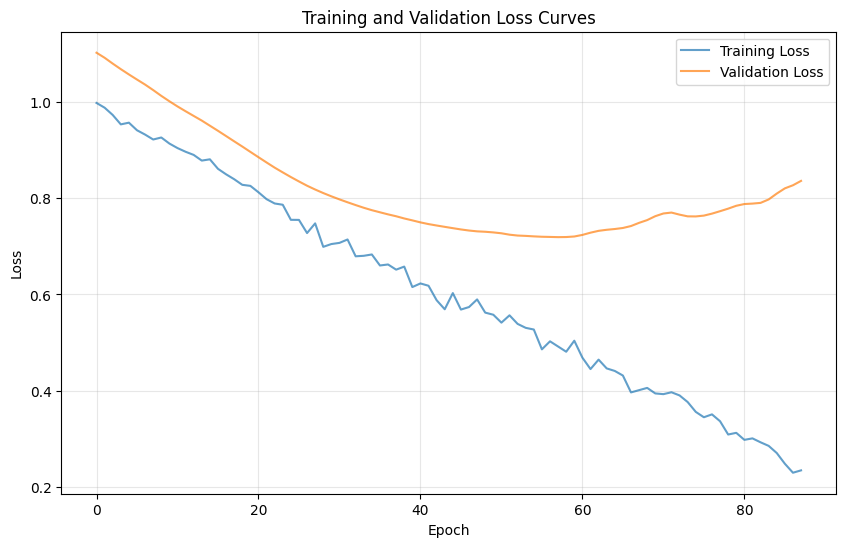


=== Final Model Evaluation ===
RMSE: 5.0874 | MAE: 3.8479 | R²: 0.2831


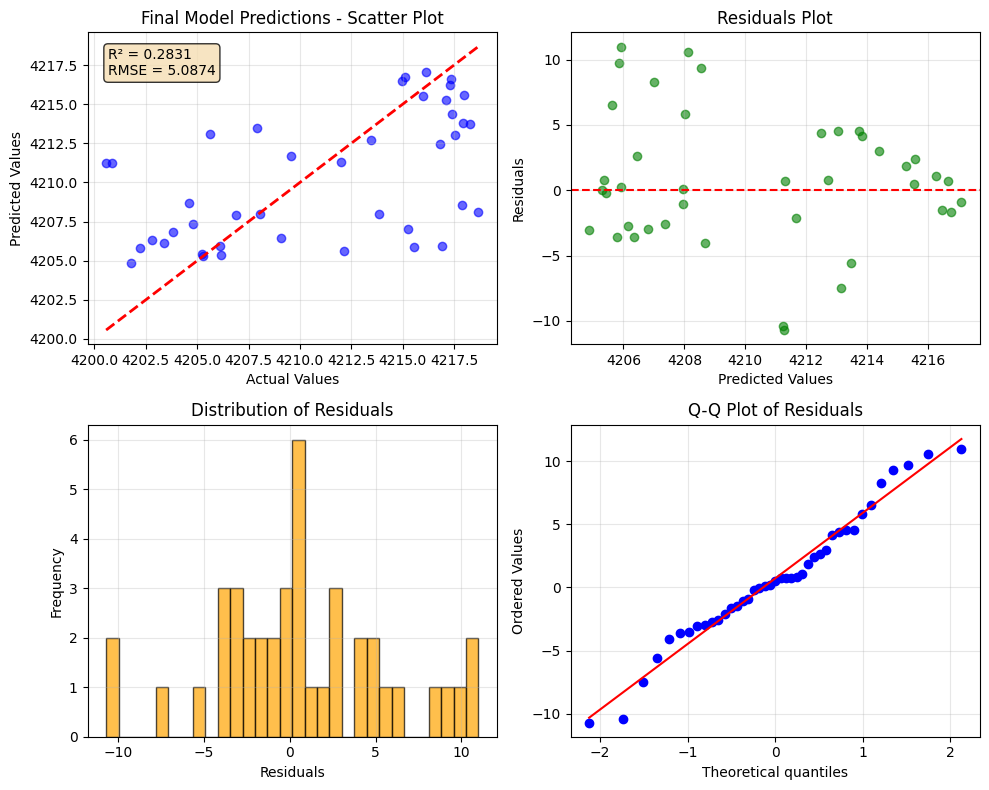

In [130]:
model, X_scaler, y_scaler, features, target = train_final_model(df)

Dataset Info:
  - Features (5): ['soilw', 'soilw_yr01', 'soilw_yr03', 'soilw_yr05', 'soilw_yr10']
  - Target: 415703112514501
  - Samples: 202
  - Feature shape: (202, 5)
  - Target shape: (202, 1)
Assuming data is already sorted chronologically
Using TimeSeriesSplit with 5 splits

=== Fold 1/5 ===
Train samples: 37 (0 to 36)
Validation samples: 33 (37 to 69)


Training:  32%|███▎      | 65/200 [00:01<00:03, 35.15it/s]


Early stopping at epoch 65
RMSE: 5.5147 | MAE: 4.7067 | R²: 0.1644

=== Fold 2/5 ===
Train samples: 70 (0 to 69)
Validation samples: 33 (70 to 102)


Training:  26%|██▋       | 53/200 [00:00<00:01, 115.04it/s]


Early stopping at epoch 53
RMSE: 5.4048 | MAE: 4.3736 | R²: 0.0896

=== Fold 3/5 ===
Train samples: 103 (0 to 102)
Validation samples: 33 (103 to 135)


Training:  26%|██▌       | 51/200 [00:00<00:01, 111.26it/s]


Early stopping at epoch 51
RMSE: 5.0743 | MAE: 4.0481 | R²: 0.2681

=== Fold 4/5 ===
Train samples: 136 (0 to 135)
Validation samples: 33 (136 to 168)


Training:  60%|██████    | 120/200 [00:01<00:00, 108.03it/s]


Early stopping at epoch 120
RMSE: 3.1540 | MAE: 2.4405 | R²: 0.6390

=== Fold 5/5 ===
Train samples: 169 (0 to 168)
Validation samples: 33 (169 to 201)


Training:  76%|███████▌  | 151/200 [00:02<00:00, 61.98it/s] 


Early stopping at epoch 151
RMSE: 4.9561 | MAE: 4.0638 | R²: 0.2585

=== Cross-Validation Results ===
Mean RMSE: 4.8208 (±0.8583)
Mean MAE: 3.9265 (±0.7811)
Mean R2: 0.2839 (±0.1892)

=== Time Series Fold Information ===
Fold | Train Range        | Val Range          | Train Size | Val Size
---------------------------------------------------------------------------
   1 |      0-    36 |     37-    69 |         37 |       33
   2 |      0-    69 |     70-   102 |         70 |       33
   3 |      0-   102 |    103-   135 |        103 |       33
   4 |      0-   135 |    136-   168 |        136 |       33
   5 |      0-   168 |    169-   201 |        169 |       33


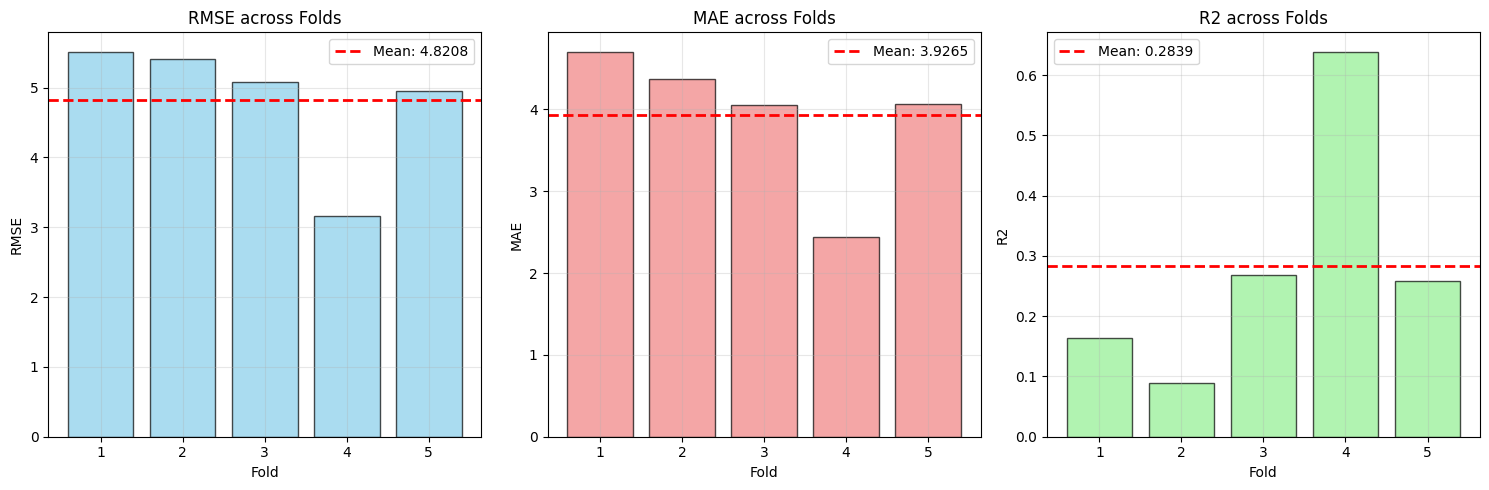

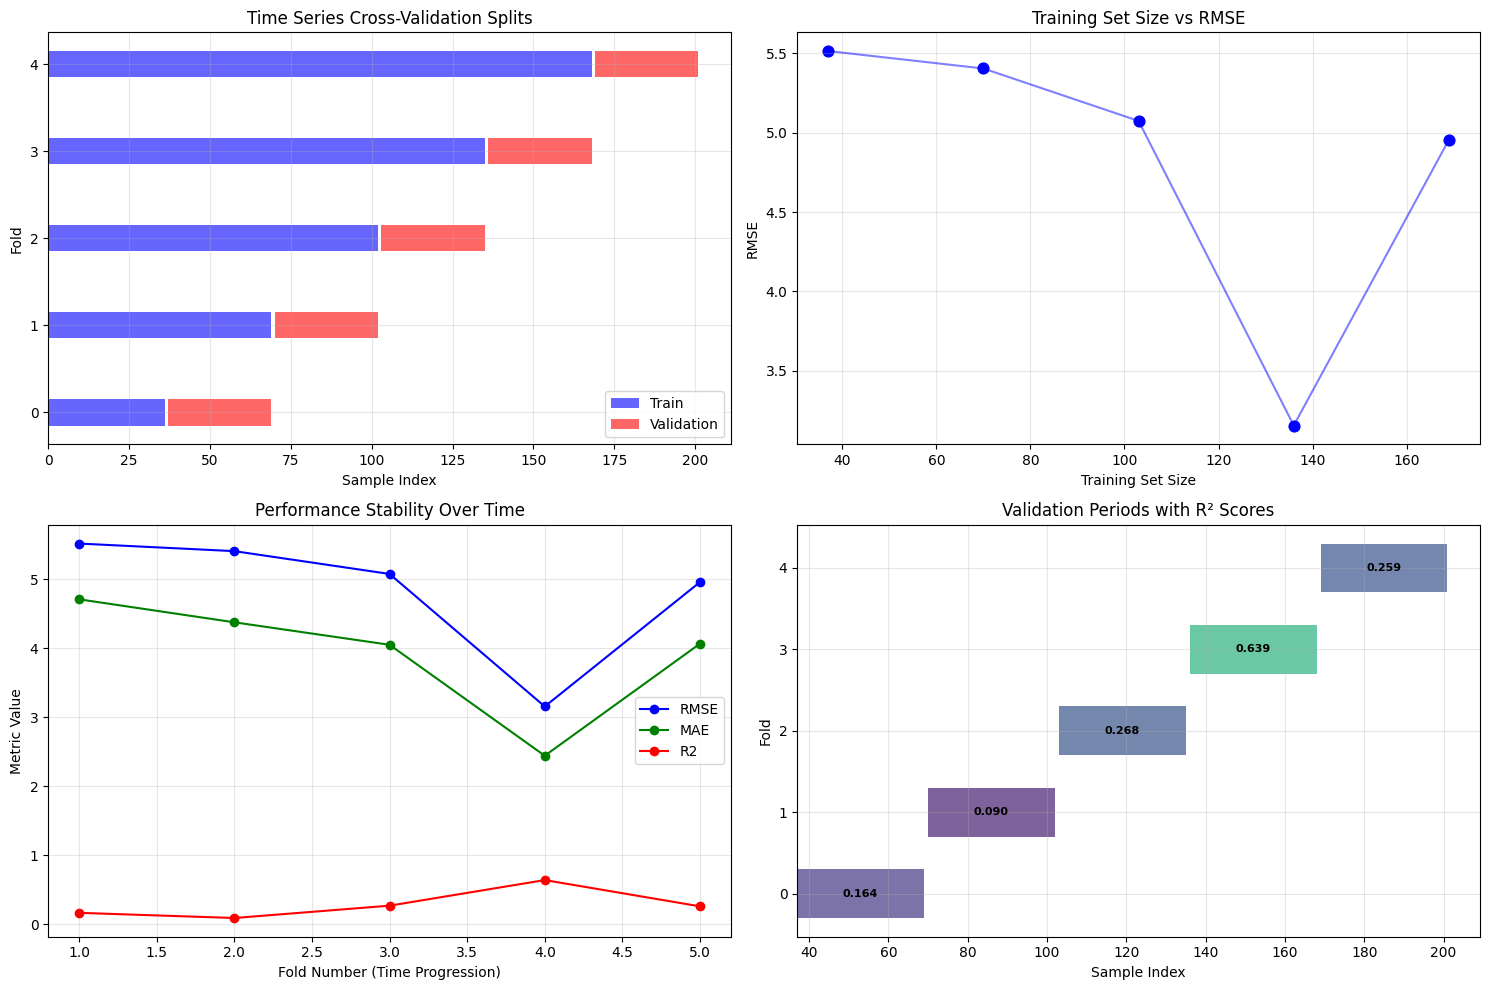

UnboundLocalError: cannot access local variable 'X_sample' where it is not associated with a value

In [131]:
models, metrics, features, target = cross_validate(df)


In [ ]:
#@markdown ### **Plot GLDAS soil moisture datasets**
fig = px.line(gldas_df, x=gldas_df.index, y=names)
fig.show()

# Temporal Interpolation

In [18]:
#@markdown ### **Saving selected parameters to summary file**
min_samples = 5 #@param {type:"integer"}
gap_size = "730" #@param {type:"string"}
pad = 180 #@param {type:"integer"}
spacing = "1MS"

In [19]:
#@markdown ### **Updating summary based on selections**
summary += "Parameters for temporal interpolation:\n"
summary += f"min samples: {min_samples}\n"
summary += f"gap size: {gap_size}\n"
summary += f"pad: {pad}\n"

In [20]:
#@markdown ### **Defining functions for this section**

def extract_well_data(name, well_df, min_samples=0, ts_col="ts_value", date_col="date"):
    if len(well_df) >= min_samples:
        # if (well_df['date'].min() < start_date) and (well_df['date'].max() > end_date):
        # elevation = well_df['gse'].unique()[0]
        df = pd.DataFrame(
            index=well_df[date_col].values,
            data=well_df[ts_col].values,
            columns=[name],
        )
        df = df[np.logical_not(df.index.duplicated())]
        return df

def interp_well(wells_df, gap_size, pad, spacing):
    well_interp_df = pd.DataFrame()
    # create a time index to interpolate over - cover entire range
    interp_index: pd.DatetimeIndex = pd.date_range(
        start=min(wells_df.index), freq=spacing, end=max(wells_df.index)
    )
    # loop over each well, interpolate data using pchip
    for well in wells_df:
        temp_df = wells_df[well].dropna()  # available data for a well
        x_index = temp_df.index.astype("int")  # dates for available data
        x_diff = temp_df.index.to_series().diff()  # data gap sizes
        fit2 = interpolate.pchip(x_index, temp_df)  # pchip fit to data
        ynew = fit2(interp_index.astype("int"))  # interpolated data on full range
        interp_df = pd.DataFrame(ynew, index=interp_index, columns=[well])

        # replace data in gaps of > gap_size with nans
        gaps = np.where(x_diff > gap_size)  # list of indexes where gaps are large
        for g in gaps[0]:
            start = x_diff.index[g - 1] + datetime.timedelta(days=pad)
            end = x_diff.index[g] - datetime.timedelta(days=pad)
            interp_df[start:end] = np.nan
        beg_meas_date = x_diff.index[0]  # date of 1st measured point
        end_meas_date = temp_df.index[-1]  # date of last measured point

        mask1 = (
            interp_df.index < beg_meas_date
        )  # locations of data before 1st measured point

        interp_df[mask1] = np.nan  # blank out data before 1st measured point

        mask2 = (
            interp_df.index >= end_meas_date
        )  # locations of data after the last measured point

        interp_df[mask2] = np.nan  # blank data from last measured point

        # add the interp_df data to the full data frame

        well_interp_df = pd.concat(
            [well_interp_df, interp_df], join="outer", axis=1, sort=False
        )
    return well_interp_df

def norm_training_data(in_df, ref_df):
    norm_in_df = (in_df - ref_df.min().values) / (
        ref_df.max().values - ref_df.min().values
    )  # use values as df sometimes goofs
    return norm_in_df

def zscore_training_data(in_df, ref_df):
    norm_in_df = (in_df - ref_df.mean().values) / ref_df.std().values
    return norm_in_df

def input_to_hidden(x, Win, b):
    # setup matrixes
    a = np.dot(x, Win) + b
    a = np.maximum(a, 0, a)  # relu
    return a

def predict(in_values, W_in, b, W_out):
    x = input_to_hidden(in_values, W_in, b)
    y = np.dot(x, W_out)
    return y

def impute_data(comb_df, well_names, names):
    # for our test set we will impute everything
    imputed_df = pd.DataFrame(index=comb_df.index)

    for well in well_names:  # list of the wells in the aquifer
        train_nona_df = comb_df.dropna(
            subset=[well]
        )  # drop any rows with na in well (measured) data
        labels_df = train_nona_df[
            well
        ]  # measured data used as "labels" or truth in training
        tx_df = train_nona_df[
            names
        ]  # data we will predict with only over the test period
        all_tx_df = comb_df[names]  # data over the full period, will use for imputation

        tx = tx_df.values  # convert to an array
        x1 = np.column_stack(np.ones(tx.shape[0])).T  # bias vector of 1's
        tx = np.hstack((tx, x1))  # training matrix
        ty = labels_df.values
        input_length = tx.shape[1]
        hidden_units = 500
        lamb_value = 100
        W_in = np.random.normal(size=[input_length, hidden_units])
        b = np.random.normal(size=[hidden_units])

        # now do the matrix multiplication
        X = input_to_hidden(
            tx, W_in, b
        )  # setup matrix for multiplication, it is a function
        I = np.identity(X.shape[1])
        I[X.shape[1] - 1, X.shape[1] - 1] = 0
        I[X.shape[1] - 2, X.shape[1] - 2] = 0
        W_out = np.linalg.lstsq(X.T.dot(X) + lamb_value * I, X.T.dot(ty), rcond=-1)[0]
        all_tx_values = all_tx_df.values
        a1 = np.column_stack(np.ones(all_tx_values.shape[0])).T
        all_tx_values = np.hstack((all_tx_values, a1))
        predict_values = predict(all_tx_values, W_in, b, W_out)  # it is a function
        #pre_name = f"{well}_imputed"
        pre_name = f"{well}"
        imputed_df[pre_name] = pd.Series(predict_values, index=imputed_df.index)

    return imputed_df

def renorm_data(in_df, ref_df):
    assert in_df.shape[1] == ref_df.shape[1], "must have same # of columns"
    renorm_df = (
        in_df * (ref_df.max().values - ref_df.min().values)
    ) + ref_df.min().values
    return renorm_df

def reverse_zscore_data(in_df, ref_df):
    assert in_df.shape[1] == ref_df.shape[1], "must have same # of columns"
    renorm_df = (
        in_df * ref_df.std().values
    ) + ref_df.mean().values
    return renorm_df


In [21]:
#@markdown ### **Collect well data that qualifies for use in interpolation**
wells_df = pd.concat([
        extract_well_data(name, group, min_samples, ts_measurement.value, ts_date.value)
        for name, group in measurements.groupby(ts_well_ID.value)],
    axis=1, sort=False,)
wells_qual = wells_gdf[wells_gdf[w_well_ID.value].isin(wells_df.columns.values)].reset_index(drop=True)
# made a data fram called wells_drop that includes wells no in
wells_drop = wells_gdf[~wells_gdf[w_well_ID.value].isin(wells_df.columns.values)]

In [22]:
#@markdown ### **Cleaning up wells dataframe**
wells_df.drop_duplicates(inplace=True)
wells_df[wells_df == 0] = np.nan
wells_df.dropna(thresh=min_samples, axis=1, inplace=True)
no_qualifiedwells = len(wells_df.columns.values)
no_droppedwells = no_uniquewells - no_qualifiedwells
#Update summary based on selections
summary += f"number of wells dropped: {no_droppedwells}\n"
summary += f"number of wells qualified for use in interpolation: {no_qualifiedwells}\n"
print(no_wells,  ' total wells')
print(no_uniquewells,  ' wells with measurements')
print(no_droppedwells,  ' wells dropped')
print(no_qualifiedwells,  ' qualified for use in interpolation')

8752  total wells
8602  wells with measurements
6265  wells dropped
2337  qualified for use in interpolation


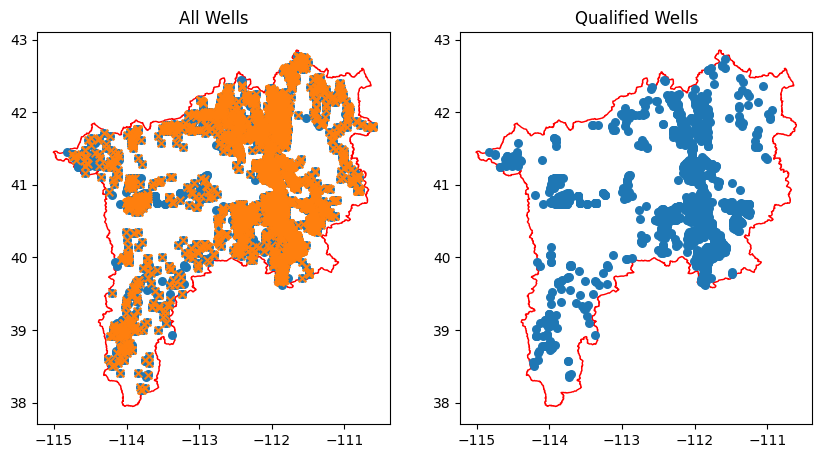

In [23]:
#@markdown ### **Plot wells that are dropped**
fig, ax = plt.subplots(1,2)
# add plot titles
ax[0].set_title('All Wells')
ax[1].set_title('Qualified Wells')
aquifer.plot(color="none", edgecolor="red", ax=ax[0])
aquifer.plot(color="none", edgecolor="red", ax=ax[1])
wells_gdf.plot(ax=ax[0],  markersize = 30, marker = 'o')
if not wells_drop.empty:
  wells_drop.plot(ax=ax[0],  markersize = 30, marker = 'x')
wells_qual.plot(ax=ax[1],  markersize = 30, marker = 'o')
fig.set_size_inches(10, 10)

In [24]:
#@markdown ### **Running simple pchip temporal interpolation**
well_interp_df = interp_well(wells_df, gap_size, pad, spacing)
well_interp_df.dropna(thresh=min_samples, axis=1, inplace=True)
#well_interp_df

In [ ]:
#@markdown ### **Create combined plot of all PCHIP time series**
%%capture
wells_df.dropna()
wells_date =  pd.to_datetime(wells_df.index.values)
interp_date =  pd.to_datetime(well_interp_df.index.values)
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(wells_date, wells_df, "o") #measurements
ax.plot(interp_date, well_interp_df) #pchip

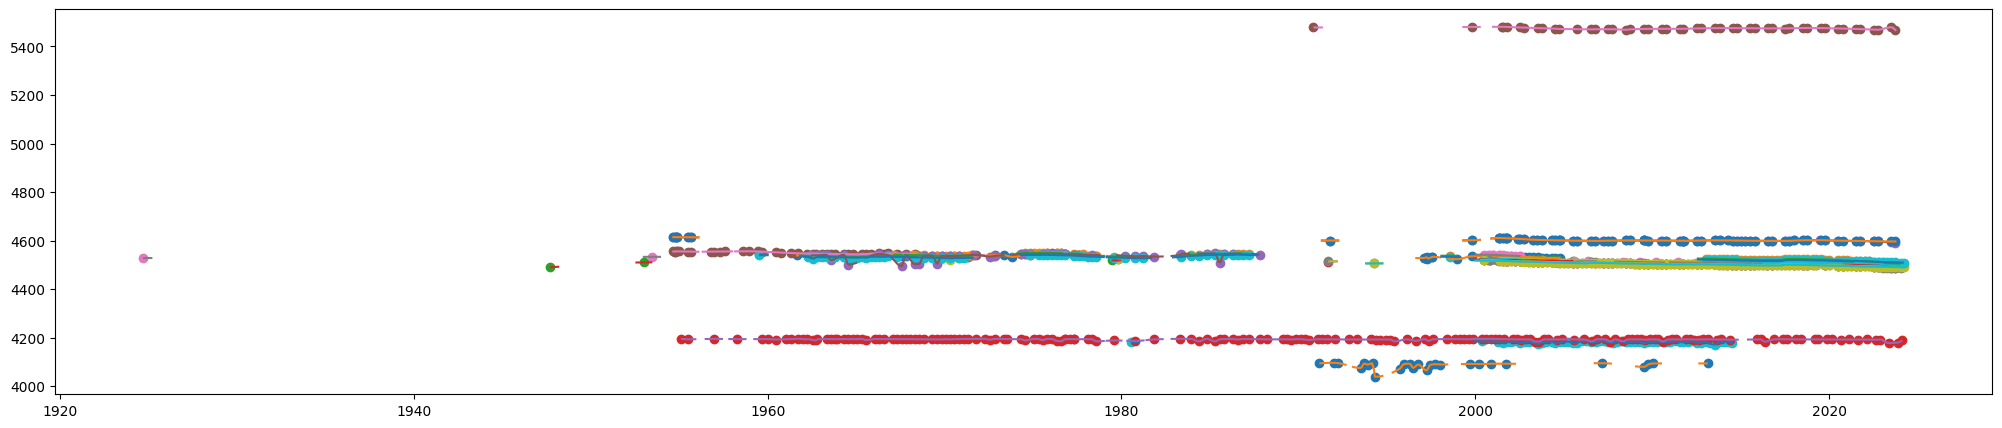

In [ ]:
#@markdown ### **View combined plot of all PCHIP time series**
fig

# Imputation via Machine Learning

In [25]:
#@markdown ### **Combining data frames**
# combine the  data from the wells and the satellite observations to a single dataframe (combined_df)
# this will have a row for every measurement (on the start of the month) a column for each well,
# and a column for soilw and its rolling averages, etc
combined_df = pd.concat(
    [well_interp_df, gldas_df], join="outer", axis=1, sort=False
)
combined_df.dropna(
    subset=names, inplace=True
)  # drop rows where there are no satellite data
combined_df.dropna(how="all", axis=1, inplace=True)
#combined_df

In [26]:
#@markdown ### **Applying z-score normalization to water level and soilw data**
# Use z-score normalization to normalize all of the numeric columns in combined_df
norm_df = zscore_training_data(combined_df, combined_df)
norm_df.dropna(how="all", axis=1, inplace=True)
#norm_df

In [27]:
#@markdown ### **Adding and normalizing a year feature**
# Add a year column and normalize using max min method (not zscore)
norm_df['year'] = norm_df.index.year
norm_df['year'] = (norm_df['year'] - norm_df['year'].min()) / (norm_df['year'].max() - norm_df['year'].min())
# append the new year column name to the names list (list of features)
names.append('year')

In [28]:
#@markdown ### **Adding one-hot encoded month features**
# Add one-hot encoded month indices as zeroes and ones
norm_df['month'] = norm_df.index.month
norm_df = pd.get_dummies(norm_df, columns=['month'], dtype=float)
# find all columns in norm_df that inclued 'month_' in the column name and add those column names to the names list
col_names = norm_df.columns.values
for col in col_names:
  col_str = str(col)
  if 'month_' in col_str:
     names.append(col_str)
print(names)
#norm_df

['soilw', 'soilw_yr01', 'soilw_yr03', 'soilw_yr05', 'soilw_yr10', 'year', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


In [29]:
#@markdown ### **Performing the imputation**
%%capture
well_names = [col for col in well_interp_df.columns if col in norm_df.columns]
imputed_norm_df = impute_data(norm_df, well_names, names)
ref_df = combined_df[well_names]

# Reverse zscore normalization. This should not be applied to years or months. FIX LATER?
# imputed_df = renorm_data(imputed_norm_df, ref_df)
imputed_df = reverse_zscore_data(imputed_norm_df, ref_df)

# Create list of imputed names (WHY ARE WE DOING THIS?)
imputed_well_names = imputed_df.columns  # create a list of well names
loc_well_names = [(strg.replace("_imputed", "")) for strg in imputed_well_names]  # strip off "_imputed"
#imputed_df

In [30]:
#@markdown ### **Merging measurement, pchip, and machine learning dataframes**
#formating column names to match so that the dataframes can be combined
well_interp_columns = []
for i in range(len(well_interp_df.columns)) : well_interp_columns.append(str(well_interp_df.columns[i]))
well_interp_df.columns = well_interp_columns

imputed_columns = []
for i in range(len(imputed_df.columns)) : imputed_columns.append(str(imputed_df.columns[i]))
imputed_df.columns = imputed_columns

#replacing the machine learning values with pchip values when available
replaced_df = well_interp_df.combine_first(imputed_df)
#replaced_df

# Plot Imputation Results

In [122]:
replaced_df[replaced_df.index.year>2000]

,382113113435401,382259113433701,382402113421101,383023114115302,383325114134901,383357113440601,383402113440601,383533114102901,384112114091101,384227114082701,...,422531112243201,422837111221601,423045111450001,423433111484701,423504111482801,423621111343301,423652111463001,423806111371601,423848111372801,424340111344101
2001-01-01,5399.038810,5317.256585,4964.397002,5665.676938,5674.529691,4809.123736,4814.672747,5686.861066,5664.354271,5587.856160,...,5506.622984,5993.817101,5315.394130,5424.370813,5416.460448,5819.272515,5420.242866,5728.424846,5731.705495,5997.914799
2001-02-01,5399.007429,5317.265361,4964.369624,5665.415801,5673.419784,4809.080645,4814.694787,5688.021618,5664.064402,5587.788909,...,5506.653519,5994.188367,5314.880245,5423.496385,5415.525259,5819.528979,5419.307628,5727.930582,5731.669791,5998.230277
2001-03-01,5398.954443,5317.249646,4964.299435,5665.159467,5677.829781,4809.107504,4814.699739,5676.448233,5663.639479,5587.785345,...,5506.693690,5993.501420,5314.563224,5422.701487,5414.634796,5819.452031,5418.500023,5728.075703,5731.662703,5998.432601
2001-04-01,5399.059001,5317.304205,4964.287527,5664.930385,5676.746029,4809.011345,4814.693713,5679.802060,5663.400066,5587.615717,...,5506.690676,5993.885044,5314.509713,5422.033122,5413.656915,5819.494741,5417.813091,5727.266416,5731.648710,5998.482691
2001-05-01,5398.943290,5317.383311,4964.354437,5664.840000,5678.038890,4809.025038,4814.692133,5675.945984,5663.122629,5587.807797,...,5506.657533,5991.747482,5315.505695,5421.539174,5412.722950,5819.304865,5417.255202,5727.131832,5731.650929,5997.949325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,5398.068511,5318.003334,4966.651409,5660.075416,5653.490009,4809.386584,4814.665509,5579.648349,5661.202772,5585.475421,...,5506.631612,5990.647959,5315.827671,5416.168788,5405.153069,5819.640013,5415.075786,5729.988176,5731.044666,5994.101285
2023-09-01,5397.848931,5318.010266,4966.469779,5660.634887,5653.206984,4809.233390,4814.634202,5577.136075,5661.643462,5585.570959,...,5506.612254,5992.049368,5316.557669,5421.064428,5412.889727,5819.728932,5415.924494,5730.508329,5731.145310,5993.397455
2023-10-01,5397.715214,5318.056604,4966.453516,5661.074453,5653.197080,4809.219278,4814.510126,5578.576064,5661.911383,5585.689366,...,5506.582695,5991.627682,5315.986578,5418.198873,5414.386742,5819.695790,5416.024564,5730.454860,5731.237956,5993.025538
2023-11-01,5397.608609,5318.055766,4966.730682,5661.243140,5653.376036,4809.269795,4814.595105,5581.266035,5662.138286,5585.840252,...,5506.502274,5990.396406,5315.585805,5419.323341,5414.711043,5819.480489,5416.558801,5730.294910,5731.165538,5993.068851


In [ ]:
#@markdown ### **Defining functions for this section**
def plot_well(well_no, well_name):
  #plotting the three dataframes: measurements, pchip, and machine learning
  fig, ax = plt.subplots(2, 1, figsize=(25,10))
  #ax.set_xlim([datetime.date(2001, 1, 26), datetime.date(2021, 2, 1)])
  ax[0].plot(imputed_date, imputed_df[imputed_df.columns[well_no]]) #machine learning (blue)
  ax[0].plot(interp_date, well_interp_df[well_interp_df.columns[well_no]], color = 'red') #pchip
  ax[0].plot(wells_date, wells_df[wells_df.columns[well_no]], marker = "o", linestyle = 'none', color = 'green') #measurements
  ax[1].plot(replaced_date, replaced_df[replaced_df.columns[well_no]], color = 'purple')
  ax[0].set_title('Well ID = ' + well_name)
  ax[1].set_title('Well ID = ' + well_name)
  ax[0].set_ylabel(f'Water Level ({len_units})')
  ax[1].set_ylabel(f'Water Level ({len_units})')
  ax[0].set_xlabel('Date')
  ax[1].set_xlabel('Date')
  # add legend
  ax[0].legend(['Imputed', 'PCHIP', 'Measurements'])
  ax[1].legend(['Combined Imputed+PCHIP'])
  return fig

def build_well_df(well_no, well_name):
  # Creates a dataframe for the selected well with everything referenced
  # to a common set of dates. Call this before saving to CVS or XLSX
  well_df = pd.DataFrame()

  # Use the imputed_date index for all data
  well_df['Date'] = imputed_date
  well_df.set_index('Date', inplace=True)
  well_df.index = pd.to_datetime(well_df.index)

  # The measurment in the wells_df are at random dates, but each of the other datasets
  # are one value per month at the first of the month (MS). We need to get the measurements
  # for the first of the month for each well.
  well_df['Measurements'] = wells_df[wells_df.columns[well_no]].resample('MS').first()

  # Add the other datasets without modification to the dataframe
  well_df['PCHIP'] = well_interp_df[well_interp_df.columns[well_no]]
  well_df['Imputed'] = imputed_df[imputed_df.columns[well_no]]
  well_df['Combined'] = replaced_df[replaced_df.columns[well_no]]
  return well_df

def datetime_to_excel_serial_date(date):
    # Convert a datetime object to an Excel serial date
    excel_base_date = datetime.datetime(1899, 12, 30)  # Excel's base date is December 30, 1899
    delta = date - excel_base_date
    excel_serial_date = delta.days + delta.seconds / (24 * 60 * 60)  # Include fraction of a day
    return excel_serial_date

def export_well_to_excel(well_no, well_name):
  wb = xlsxwriter.Workbook(f'{well_name}.xlsx')
  sheet = wb.add_worksheet()
  sheet.title = 'Sheet1'

  heading_format = wb.add_format()
  heading_format.set_bold()
  heading_format.set_align('center')
  heading_format.set_border()

  #headings = ['Date', 'Measurements', '', 'Date', 'PCHIP', 'Imputed', 'Combined']
  #sheet.write_row('A1', headings, heading_format)
  sheet.write('A1', 'Date', heading_format)
  sheet.write('B1', 'Measurements', heading_format)
  sheet.write('D1', 'Date', heading_format)
  sheet.write('E1', 'PCHIP', heading_format)
  sheet.write('F1', 'Imputed', heading_format)
  sheet.write('G1', 'Combined', heading_format)

  date_format = wb.add_format()
  date_format.set_num_format('yyyy-mm-dd')
  date_format.set_align('center')
  date_format.set_border()

  num_format = wb.add_format()
  num_format.set_num_format('0.0')
  num_format.set_align('center')
  num_format.set_border()

  len_units = 'ft'

  # export measurements to the first two columns from selected well to sheet
  well_meas_df = wells_df[wells_df.columns[well_no]]
  well_meas_df.dropna(inplace=True)
  well_meas_df.index = pd.to_datetime(well_meas_df.index)
  sheet.write_column('A2', well_meas_df.index, date_format)
  sheet.set_column('A:A', 10)
  sheet.write_column('B2', well_meas_df, num_format)
  sheet.set_column('B:B', 12)
  num_meas_rows = len(well_meas_df)

  # export the other monthly datasets to a separate column
  well_df = build_well_df(well_no, well_name)
  well_df = well_df.replace({np.nan: None})
  sheet.write_column('D2', imputed_date, date_format)
  sheet.set_column('D:D', 10)
  sheet.write_column('E2', well_df['PCHIP'], num_format)
  sheet.write_column('F2', well_df['Imputed'], num_format)
  sheet.write_column('G2', well_df['Combined'], num_format)
  sheet.hide_gridlines(2)

  num_rows = len(well_df)
  chart1 = wb.add_chart({'type': 'scatter', 'subtype': 'smooth'})

  # add series in reverse order so that PCHIP and measurements are drawn last
  # plot combined with a wide line

  chart1.add_series({  # combined
      'name':       f'=Sheet1!$G$1',
      'categories': f'=Sheet1!$D$2:$D${num_rows+1}',
      'values':     f'=Sheet1!$G$2:G${num_rows+1}',
      'line':       {'color': '#D7E4BD', 'width': 8.0},
  })
  chart1.add_series({  # imputed
      'name':       f'=Sheet1!$F$1',
      'categories': f'=Sheet1!$D$2:$D${num_rows+1}',
      'values':     f'=Sheet1!$F$2:$F${num_rows+1}',
      'line':       {'color': '#00B0F0', 'width': 1.5},
  })
  chart1.add_series({  # PCHIP
      'name':       f'=Sheet1!$E$1',
      'categories': f'=Sheet1!$D$2:$D${num_rows+1}',
      'values':     f'=Sheet1!$E2:$E${num_rows+1}',
      'line':       {'color': 'red', 'width': 1.5},
  })
  chart1.add_series({  # measurements
      'name':       f'=Sheet1!$B$1',
      'categories': f'=Sheet1!$A$2:$A${num_meas_rows+1}',
      'values':     f'=Sheet1!$B$2:$B${num_meas_rows+1}',
      'line':       {'none': True},
      'marker':     {'type': 'circle', 'size': 6, 'fill': {'color': 'green'}, 'border': {'color': 'green'}}
  })

  first_date = datetime_to_excel_serial_date(imputed_date[0])
  last_date = datetime_to_excel_serial_date(imputed_date[-1])
  ma_unit = (last_date - first_date) / 14
  mi_unit = ma_unit / 5
  chart1.set_x_axis({'date_axis': True,
                    'min': first_date - 300,
                    'max': last_date + 300,
                    'num_format': 'yyyy',
                    'major_unit': ma_unit,
                    'minor_unit': mi_unit
  })
  chart1.set_title ({'name': f'Well = {well_name}'})
  chart1.set_legend({'position': 'top'})
  chart1.set_y_axis({'name': f'Water Level ({len_units})'})
  chart1.set_style(11)
  sheet.insert_chart('I2', chart1, {'x_scale': 3.0, 'y_scale': 3.0})

  wb.set_size(2400, 1400)
  wb.close()

In [ ]:
#@markdown ### **Preparing data for plotting**
%%capture
#formatting dates for plotting
imputed_date =  pd.to_datetime(imputed_df.index.values)
replaced_date =  pd.to_datetime(replaced_df.index.values)
#ignoring NANs for plotting
well_interp_df.dropna()
wells_df.dropna()

In [ ]:
#@markdown ### **Run Cell and Select the Well you Wish to Plot**
pList = imputed_df.columns
p_index = widgets.Dropdown(options=pList, description = "Well Index")

pItems = [p_index]
print("\nSelect the well index you wish to plot")
widgets.GridBox(pItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))


Select the well index you wish to plot


GridBox(children=(Dropdown(description='Well Index', options=('KLAM0000496', 'KLAM0000522', 'KLAM0000561', 'KL…

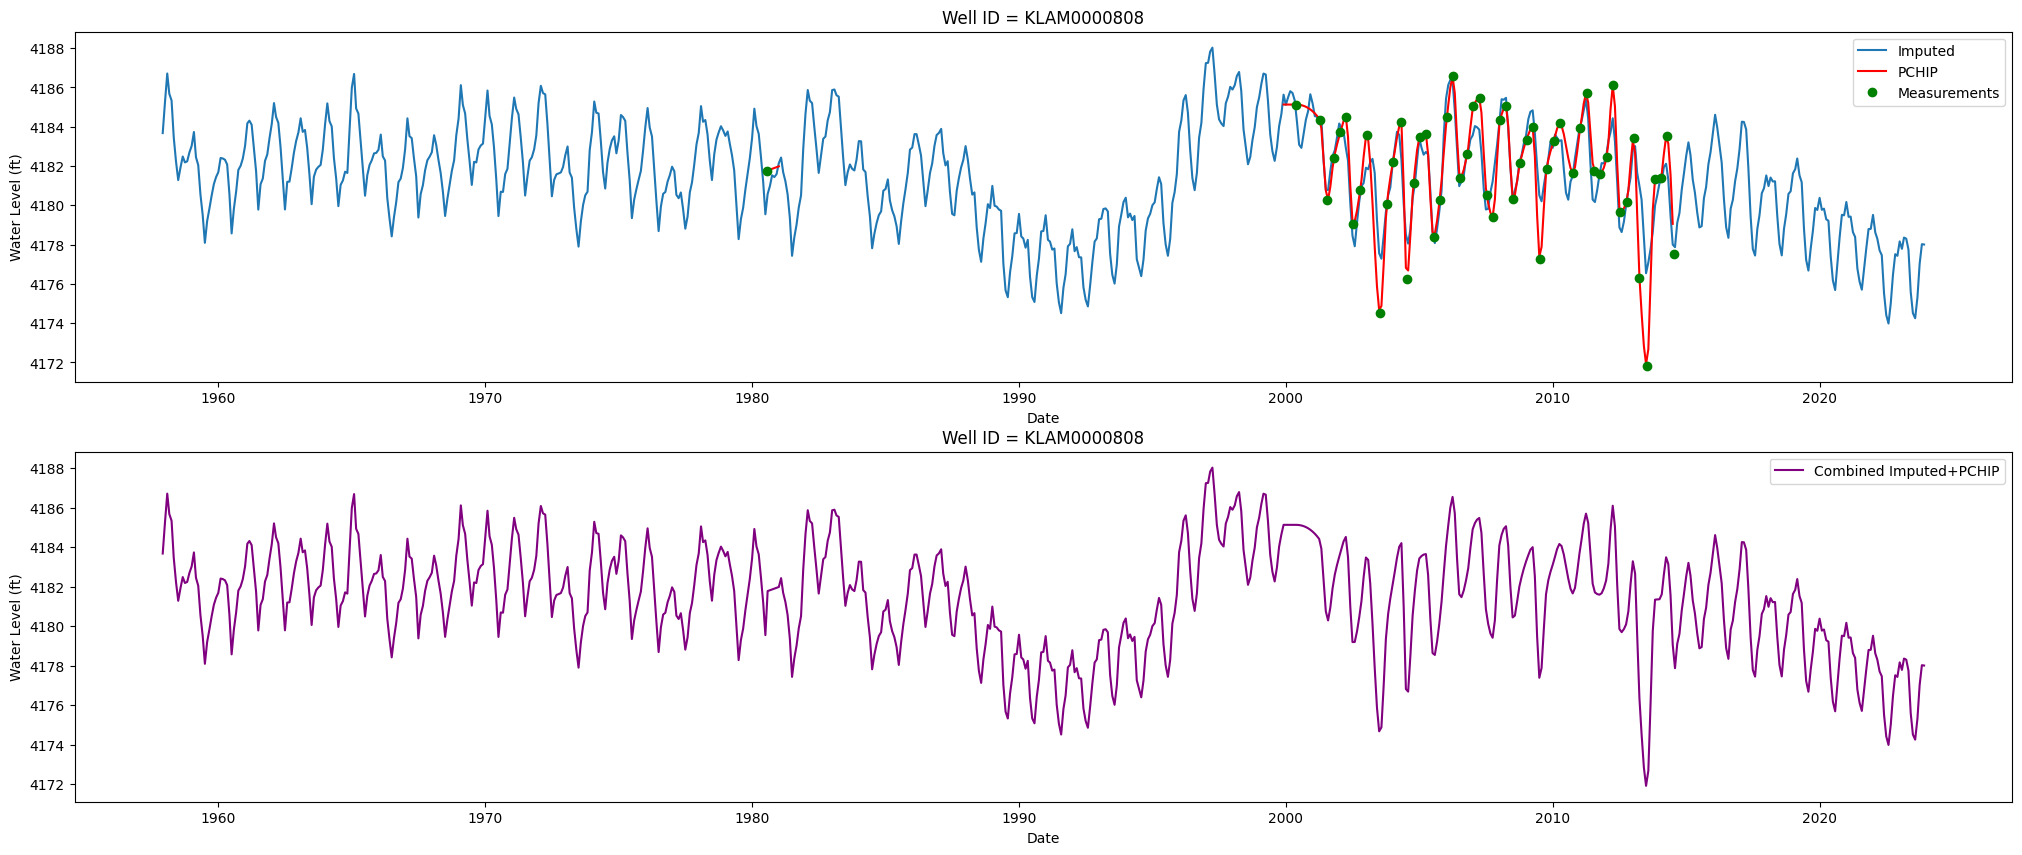

In [ ]:
#@markdown ### **Plots measurments, pchip, ml timeseries to show complete temporal interpolation**
well_no = imputed_df.columns.get_loc(p_index.value)
well_name = imputed_df.columns[well_no]
fig = plot_well(well_no, well_name)

In [ ]:
#@markdown ### **OPTIONAL - export selected well data and plot to an Excel file**
well_no = imputed_df.columns.get_loc(p_index.value)
well_name = imputed_df.columns[well_no]
export_well_to_excel(well_no, well_name)

In [ ]:
#@markdown ### **OPTIONAL - save a copy of all well plots**
well_names = imputed_df.columns
os.makedirs("well_plots", exist_ok=True)
for well_no in range(len(well_names)):
  well_name = imputed_df.columns[well_no]
  fig = plot_well(well_no, well_name)
  # save fig to PNG file
  fig.savefig(f"well_plots/{well_name}.png")
  plt.close(fig) # close figure

# create a zip archive of all of the PNG files for ease of downloading
!zip -r well_plots.zip well_plots

  adding: well_plots/ (stored 0%)
  adding: well_plots/KLAM0011774.png (deflated 6%)
  adding: well_plots/KLAM0052019.png (deflated 6%)
  adding: well_plots/KLAM0011796.png (deflated 6%)
  adding: well_plots/KLAM0000562.png (deflated 7%)
  adding: well_plots/KLAM0000496.png (deflated 7%)
  adding: well_plots/USGS1472801.png (deflated 7%)
  adding: well_plots/KLAM0000522.png (deflated 7%)
  adding: well_plots/KLAM0000808.png (deflated 5%)
  adding: well_plots/KLAM0000609.png (deflated 10%)
  adding: well_plots/KLAM0000589.png (deflated 9%)
  adding: well_plots/USGS1305201.png (deflated 8%)
  adding: well_plots/KLAM0000637.png (deflated 9%)
  adding: well_plots/USGS1344701.png (deflated 9%)
  adding: well_plots/KLAM0010791.png (deflated 6%)
  adding: well_plots/KLAM0000561.png (deflated 8%)
  adding: well_plots/KLAM0055028.png (deflated 8%)
  adding: well_plots/KLAM0000640.png (deflated 6%)
  adding: well_plots/KLAM0000588.png (deflated 8%)
  adding: well_plots/USGS1552101.png (deflated 

In [ ]:
#@markdown ### **Create combined plot of all imputed time series**
%%capture
wells_df.dropna()
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(wells_date, wells_df, "o") #measurements
ax.plot(replaced_date, replaced_df) #imputed data

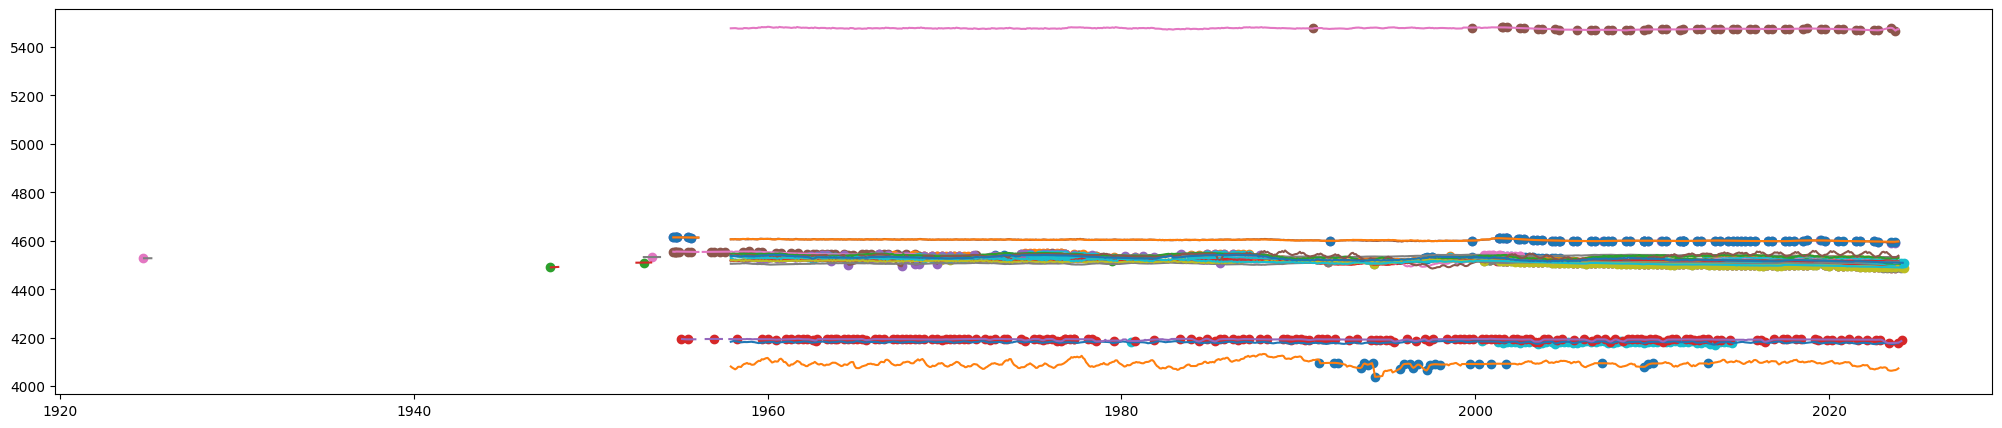

In [ ]:
#@markdown ### **View combined plot of all imputed time series**
fig

# Spatial Interpolation

In [ ]:
#@markdown ### **Setting Parameters for Spatial Interpolation**
raster_extent = "aquifer" #@param ["aquifer", "wells"]
raster_interval = 12 #@param {type:"slider", min:1, max:24, step:1}
output_file = "results.nc" #@param {type:"string"}
aquifer_name = "GSL" #@param {type:"string"}
vol_units = "acre-ft" #@param ["acre-ft", "cubic-ft", "Cubic Meter"]

#This should be the average storage coefficient for the aquifer
storage_coefficient = 0.1 #@param

start_date = 1981 #@param {type:"integer"}
end_date = 2023 #@param {type:"integer"}
#let user pick the entire date
#then if they pick an inappropriate date, give them a suggestion for the date

In [ ]:
#@markdown ### **Saving selected parameters to summary file**
summary += f"Parameters for spatial interpolation:\n"
summary += f"raster extent: {raster_extent}\n"
summary += f"raster interval: {raster_interval}\n"
summary += f"output file: {output_file}\n"
summary += f"aquifer name: {aquifer_name}\n"
summary += f"volume units: {vol_units}\n"
summary += f"storage coefficient: {storage_coefficient}\n"
summary += f"start date: {start_date}\n"
summary += f"end date: {end_date}\n"

In [ ]:
#@markdown ### **Defining functions for this section**

def create_grid_coords(x_c, y_c, x_steps, bbox, raster_extent):
    # create grid coordinates fro kriging, make x and y steps the same
    # x_steps is the number of cells in the x-direction
    min_x = min_y = max_x = max_y = None
    if raster_extent == "aquifer":
        min_x, min_y, max_x, max_y = bbox
    elif raster_extent == "wells":
        min_x, max_x = min(x_c), max(x_c)
        min_y, max_y = min(y_c), max(y_c)

    n_bin = np.absolute((max_x - min_x) / x_steps)  # determine step size (positive)
    # make grid 10 bin steps bigger than date, will give 110 steps in x-direction
    grid_x = np.arange(
        min_x - 5 * n_bin, max_x + 5 * n_bin, n_bin
    )  # make grid 10 steps bigger than data
    grid_y = np.arange(
        min_y - 5 * n_bin, max_y + 5 * n_bin, n_bin
    )  # make grid 10 steps bigger than data

    return grid_x, grid_y

def krig_field_generate(var_fitted, x_c, y_c, values, grid_x, grid_y):
    # use GSTools to krig  the well data, need coords and value for each well
    # use model variogram paramters generated by GSTools
    # fast - is faster the variogram fitting
    krig_map = gs.krige.Ordinary(var_fitted, cond_pos=[x_c, y_c], cond_val=values)
    krig_map.structured([grid_x, grid_y], chunk_size=1000)  # krig_map.field is the numpy array of values
    return krig_map

def fit_model_var(x_c, y_c, values, bbox, raster_extent):
    # fit the model varigrom to the experimental variogram
    min_x = min_y = max_x = max_y = None
    if raster_extent == "aquifer":
        min_x, min_y, max_x, max_y = bbox
    elif raster_extent == "wells":
        min_x, max_x = min(x_c), max(x_c)
        min_y, max_y = min(y_c), max(y_c)

    # first get the coords and determine distances
    x_delta = max_x - min_x  # distance across x coords
    y_delta = max_y - min_y  # distance across y coords
    max_dist = (
        np.sqrt(np.square(x_delta + y_delta)) / 4
    )  # assume correlated over 1/4 of distance
    data_var = np.var(values)
    data_std = np.std(values)
    fit_var = gs.Stable(dim=2, var=data_var, len_scale=max_dist, nugget=data_std)
    return fit_var

def generate_nc_file(
    file_name, grid_x, grid_y, years_df, x_coords, y_coords, bbox, raster_extent
):
    temp_dir = tempfile.mkdtemp()
    file_path = os.path.join(temp_dir, file_name)
    h = netCDF4.Dataset(file_path, "w", format="NETCDF4")
    lat_len = len(grid_y)
    lon_len = len(grid_x)
    time_dim = h.createDimension("time", 0)
    lat = h.createDimension("lat", lat_len)
    lon = h.createDimension("lon", lon_len)
    latitude = h.createVariable("lat", np.float64, ("lat"))
    longitude = h.createVariable("lon", np.float64, ("lon"))
    time_dim = h.createVariable("time", np.float64, ("time"), fill_value="NaN")
    ts_value = h.createVariable(
        "tsvalue", np.float64, ("time", "lon", "lat"), fill_value=-9999
    )
    latitude.long_name = "Latitude"
    latitude.units = "degrees_north"
    latitude.axis = "Y"
    longitude.long_name = "Longitude"
    longitude.units = "degrees_east"
    longitude.axis = "X"
    time_dim.axis = "T"
    time_dim.units = "days since 0001-01-01 00:00:00 UTC"

    latitude[:] = grid_y[:]
    longitude[:] = grid_x[:]

    time_counter = 0
    for measurement in years_df:
        # loop through the data
        values = years_df[measurement].values

        beg_time = timer()  # time the kriging method including variogram fitting
        # fit the model variogram to the experimental variogram
        var_fitted = fit_model_var(
            x_coords, y_coords, values, bbox, raster_extent
        )  # fit variogram
        krig_map = krig_field_generate(
            var_fitted, x_coords, y_coords, values, grid_x, grid_y
        )  # krig data
        # krig_map.field provides the 2D array of values
        end_time = timer()
        time_dim[time_counter] = measurement.toordinal()
        ts_value[time_counter, :, :] = krig_map.field
        time_counter += 1

    h.close()
    return Path(file_path)

def earth_radius(lat):
    """
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    Input
    ---------
    lat: vector or latitudes in degrees
    Output
    ----------
    r: vector of radius in meters
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    Taken from: https://gist.github.com/lgloege/3fdb1ed83b002d68d8944539a797b0bc
    """
    from numpy import deg2rad

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b ** 2 / a ** 2)

    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan((1 - e2) * np.tan(lat))

    # radius equation
    # see equation 3-107 in WGS84
    r = (a * (1 - e2) ** 0.5) / (1 - (e2 * np.cos(lat_gc) ** 2)) ** 0.5

    return r

def calculate_aquifer_area(imputed_raster, vol_units):
    y_res = abs(
        round(imputed_raster["lat"].values[0] - imputed_raster["lat"].values[1], 7)
    )  # this assumes all cells will be the same
    # size in one dimension (all cells will have same x-component)
    x_res = abs(
        round(imputed_raster["lon"].values[0] - imputed_raster["lon"].values[1], 7)
    )
    area = 0
    # Loop through each y row
    for y in range(imputed_raster.lat.size):
        # Define the upper and lower bounds of the row
        cur_lat_max = math.radians(imputed_raster["lat"].values[y] + (y_res / 2))
        cur_lat_min = math.radians(imputed_raster["lat"].values[y] - (y_res / 2))

        # Count how many cells in each row are in aquifer (i.e. and, therefore, not nan)
        x_count = np.count_nonzero(~np.isnan(imputed_raster.tsvalue[0, :, y]))

        # Area calculated based on the equation found here:
        # https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
        #     (pi/180) * R^2 * |lon1-lon2| * |sin(lat1)-sin(lat2)|
        radius = earth_radius(imputed_raster["lat"].values[y])
        if vol_units == "acre-ft":
            area_factor = 1 / 4046.8564224
        elif vol_units == "cubic-ft":
            area_factor = 10.764
        else:
            area_factor = 1
        area += (
            radius ** 2
            * area_factor
            * math.radians(x_res * x_count)
            * abs((math.sin(cur_lat_min) - math.sin(cur_lat_max)))
        )

    return area

In [ ]:
#@markdown ### **Setting up inputs used to create nc file**
coords_df = wells_gdf[wells_gdf[w_well_ID.value].astype(str).isin(loc_well_names)]
x_coords = coords_df[w_long.value].values
y_coords = coords_df[w_lat.value].values

x_steps = 150  # steps in x-direction, number of y-steps will be computed with same spacing, adds 10%
grid_x, grid_y = create_grid_coords(
    x_coords, y_coords, x_steps, bbox, raster_extent
)  # coordinates for x and y axis - not full grid

# Filter the imputed dataframe to the selected date range
filtered_df = replaced_df[
    (replaced_df.index >= f"{start_date}-01-01")
    & (replaced_df.index <= f"{end_date}-12-31")
]

# extract every nth month of data and transpose array
years_df = filtered_df.iloc[
    raster_interval-1::raster_interval # start at nth month (index starts at zero), and select every nth month after that
].T
#years_df

In [ ]:
#@markdown ### **Generating nc file using kriging**
file_name = f"{aquifer_name}_{time.time()}.nc"
nc_file_path = generate_nc_file(file_name, grid_x, grid_y, years_df, x_coords, y_coords, bbox, raster_extent)

In [ ]:
#@markdown ### **Assigning dimensions and clipping nc file**
file_path = nc_file_path
temp_dir = file_path.parent.absolute()
interp_nc = xarray.open_dataset(file_path)
interp_nc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
interp_nc.rio.write_crs("epsg:4326", inplace=True)
clipped_nc = interp_nc.rio.clip(aquifer.geometry.apply(mapping), crs=4326, drop=True)

In [ ]:
#@markdown ### **Calculating drawdown**
area_units = f'{len_units}^2'
area = calculate_aquifer_area(clipped_nc, vol_units)
print(f'area = {area} {area_units}')

# Calculate total drawdown volume at each time step
drawdown_grid = np.zeros(
    (clipped_nc.time.size, clipped_nc.lon.size, clipped_nc.lat.size)
)
drawdown_volume = np.zeros(clipped_nc.time.size)
for t in range(clipped_nc.time.size):
    # Calculate drawdown at time t by subtracting original WTE at time 0
    drawdown_grid[t, :, :] = (
        clipped_nc["tsvalue"][t, :, :] - clipped_nc["tsvalue"][0, :, :]
    )
    # Average drawdown across entire aquifer x storage_coefficient x area of aquifer
    drawdown_volume[t] = np.nanmean(
        drawdown_grid[t, :, :] * storage_coefficient * area
    )
    print(f"time = {t}, drawdown_volume = {drawdown_volume[t]}")
clipped_nc.attrs = {"area": area, "units": area_units}
clipped_nc["drawdown"] = (["time", "lon", "lat"], drawdown_grid)
clipped_nc["volume"] = (["time"], drawdown_volume, {"units": vol_units})

area = 924044.5358768582 ft^2
time = 0, drawdown_volume = 0.0
time = 1, drawdown_volume = -184831.3984524688
time = 2, drawdown_volume = -97394.63778011515
time = 3, drawdown_volume = 46488.905698844996
time = 4, drawdown_volume = 46969.93994146717
time = 5, drawdown_volume = 126948.00704593897


In [ ]:
#@markdown ### **Saving to notebook**
clipped_nc.to_netcdf(aquifer_name + "_" + output_file)

# Drawdown Curve

Text(0.5, 1.0, 'GSL Drawdown Curve')

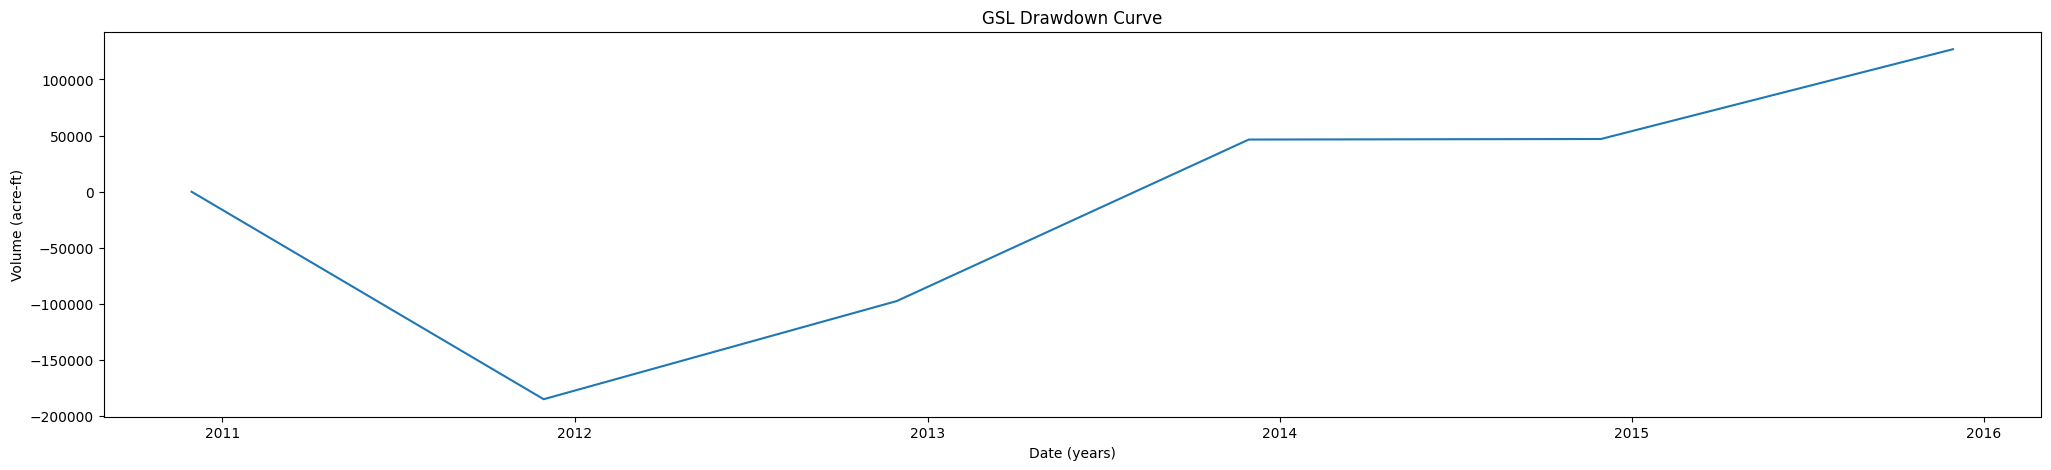

In [ ]:
#@markdown ### **Plotting the Drawdown Curve**
nc = xarray.open_dataset('/content/'+aquifer_name + "_"+ output_file)
tm = nc.variables['time'][:]
volume = nc.variables['volume'][:]
ts = nc.variables['tsvalue'][:]

fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(tm, volume) # (BLUE)
plt.xlabel("Date (years)")
plt.ylabel("Volume ("+ vol_units +")")
plt.title(aquifer_name + " Drawdown Curve")
### don't clip it so we can see the whole curve from machine learning

In [ ]:
#@markdown ###  **Exporting drawdown curve to CSV file**
drawdown_df = pd.DataFrame({'Time': tm, 'Volume': volume})
drawdown_df.to_csv(aquifer_name + "_" + "drawdown.csv")
#drawdown_df

# Animated GIF of Water Levels

In [ ]:
#@markdown ###  **Installing packages used in this section**
%%capture
!pip install basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from os import path
import glob
from PIL import Image

In [ ]:
#@markdown ### **Setting Parameters for GIF Animation**
gif_width = 8 #@param {type:"slider", min:5, max:25, step:1}
gif_transparency = 0 #@param {type:"slider", min:0, max:100, step:5}
base_map = "World_Street_Map" #@param ["World_Topo_Map", "NatGeo_World_Map", "USA_Topo_Maps", "World_Imagery", "World_Physical_Map", "World_Shaded_Relief", "World_Street_Map", "World_Terrain_Base"]
display_year = "yes" #@param ["yes", "no"]

In [ ]:
#@markdown ### **Saving selected parameters to summary file**
summary += f"Parameters for GIF Animation:\n"
summary += f"gif transparency: {gif_transparency}\n"
summary += f"gif width: {gif_width}\n"
summary += f"basemap: {base_map}\n"
summary += f"display year: {display_year}\n"

In [ ]:
#@markdown ###  **Setting map bounds**
leftbound = bbox[0]
bottombound = bbox[1]
rightbound = bbox[2]
topbound = bbox[3]
Frame_Cushion = 0.15

In [ ]:
#@markdown ###  **Setting up the time index for the GIF**
starttime = np.datetime64(f"{start_date+1}-04-01", 'M')
endtime = np.datetime64(f"{end_date-1}-12-31", 'M')
startindex, endindex = -1, -1
for i in range(len(nc['time'][:])):
  check = np.datetime64(nc.coords['time'].values[i], 'M')
  if starttime < check and startindex == -1:
    startindex = i-1
  if endtime <= check and endindex == -1:
    endindex = i

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-122.32221951599988,42.265926701739225,-121.14672688199985,43.492727510000144&bboxSR=4326&imageSR=4326&size=320,333&dpi=100&format=png32&transparent=true&f=image
processing image 1 of 6
processing image 2 of 6
processing image 3 of 6
processing image 4 of 6
processing image 5 of 6
processing image 6 of 6


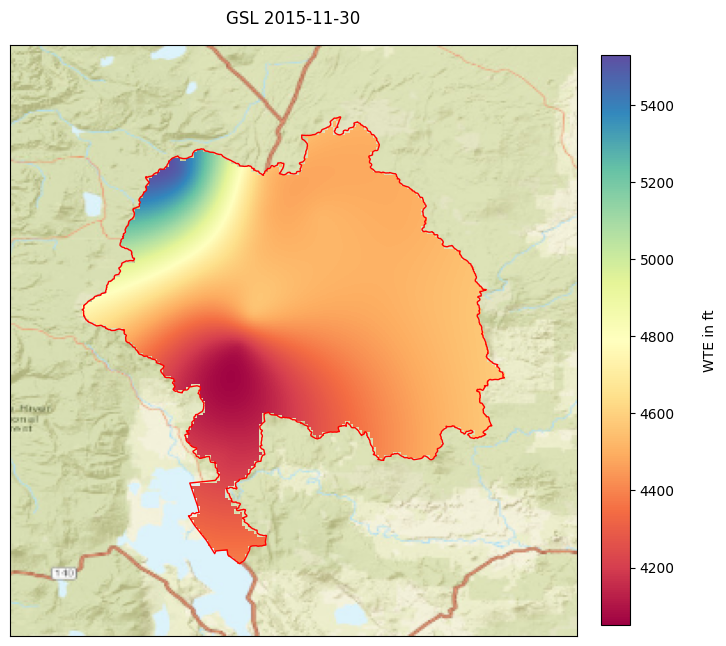

In [ ]:
#@markdown ###  **Generating individual frames**

if path.exists('/content/images_gif') == False:
  os.mkdir('/content/images_gif')

gif_height = gif_width * (topbound - bottombound) / (rightbound - leftbound)
fig, ax = plt.subplots(figsize=(gif_width, gif_height))
alpha = (100-gif_transparency)/100

aquifer.plot(color="none", edgecolor="red", ax=ax, alpha=alpha)
m = Basemap(projection='cyl', llcrnrlon=leftbound-Frame_Cushion, llcrnrlat=bottombound-Frame_Cushion, urcrnrlon=rightbound+Frame_Cushion, urcrnrlat=topbound+Frame_Cushion, resolution='i', epsg=4326)
EsriBasemaps = base_map
m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', service=EsriBasemaps, xpixels = gif_width*40, dpi = 100, verbose = True)

k=0
num_images = endindex-startindex + 1
for i in range(startindex,endindex+1):
  k+=1
  print(f'processing image {k} of {num_images}')
  im = plt.imshow(np.rot90(ts[i,:,:]), cmap="Spectral",extent=(leftbound, rightbound, bottombound, topbound) ,vmin=np.amin(ts),vmax=np.amax(ts),alpha=alpha)
  plt.title(aquifer_name.upper()+" "+str(nc.coords['time'].values[i])[:10], pad = 15)
  if i==startindex:
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label(ts_measurement.value+" in "+ len_units, labelpad = 20)
  plt.savefig(f"/content/images_gif/image{str(nc.coords['time'].values[i])[:10]}.jpg")

In [ ]:
#@markdown ###  **Combining frames into the GIF file**
#@markdown *Double-click on GIF file in files section on left to view.*
frame_duration=300
frames = []
imgs=glob.glob(f"/content/images_gif/*.jpg")
imgs.sort()
num_images = len(imgs)
k=0
for i in imgs:
    k+=1
    print(f'processing image {k} of {num_images}')
    new_frame = Image.open(i)
    frames.append(new_frame)
print("saving...")
frames[0].save(aquifer_name + '_animation.gif', format='GIF', append_images=frames[1:],save_all=True, duration = frame_duration, loop=0)
print("done!")

processing image 1 of 6
processing image 2 of 6
processing image 3 of 6
processing image 4 of 6
processing image 5 of 6
processing image 6 of 6
saving...
done!


# Export summary file of analysis parameters

In [ ]:
#@markdown ###  **Exporting analysis summary to a text file**
with open("summary.txt", "w") as f:
  f.write(summary)
  f.close()